# Base Model HMM

In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from hmmlearn import hmm


def calculate_Zscore(df, serie):
    '''
    This function calculates the Z-score of the strategy, which is an indicator of performance on risk
    A Z-score above 2 (average return above 2 standard deviations) is considered 
    '''
    this_df = deepcopy(df)
    return_series = this_df[serie].pct_change()
    return return_series.mean() / (return_series.std(ddof=1) / np.sqrt(return_series.shape))

def compare_strat_perf(train):
    '''
    This function compares the trading performance of the Long-Only strategy to the HMM based strategy
    '''
    baseline_perf   = train['Close'].iloc[-1] / train['Close'].iloc[0] - 1
    hmm_perf        = train['trading_sim'].iloc[-1] / train['trading_sim'].iloc[0] - 1
    if 'Date' not in train.columns:
        train['Date'] = train.index
    nb_years        = (datetime.strptime(train['Date'].iloc[-1], '%Y-%m-%d') - datetime.strptime(train['Date'].iloc[0], '%Y-%m-%d')).days / 365
    baseline_y_perf = (1 + baseline_perf) ** (1 / nb_years) - 1
    hmm_y_perf      = (1 + hmm_perf) ** (1 / nb_years) - 1
    
    z_score_train, z_score_test = calculate_Zscore(train, 'Close'), calculate_Zscore(train, 'trading_sim')
    print('For the buy and hold trading strategy => Overall return = %0.2f%%  ~  Yearly return = %0.2f%%  ~  Z-score = %0.3f' 
      % (100 * baseline_perf, 100 * baseline_y_perf, z_score_train))
    print('For the HMM based    trading strategy => Overall return = %0.2f%%  ~  Yearly return = %0.2f%%  ~  Z-score = %0.3f' 
      % (100 * hmm_perf, 100 * hmm_y_perf, z_score_test))
    
    return z_score_train, z_score_test

def graph_prediction(predictions, train, loser, this_set='Train'):
    '''
    This function plots a comparative graph of the Long-Only strategy and the HMM based strategy.
    It will shade the periods of the losing state, for which the HMM strategy will remain out of the market.
    '''
    predictions_start = np.where((predictions == loser) & (np.diff(np.pad(predictions, (1, 0), 'constant', constant_values=-99)) != 0))[0]
    predictions_end   = np.where((predictions == loser) & (np.diff(np.pad(predictions, (0, 1), 'constant', constant_values=-99)) != 0))[0]


    fig, ax = plt.subplots(1, 1, figsize=(16, 6))
    if 'Date' in train.columns:
        train.plot(x='Date', y='Close', color='dodgerblue', label='Long Only', ax=ax)
        train.plot(x='Date', y='trading_sim', color='orange', label='With HMM Regime detection', ax=ax)
    else:
        train.plot(y='Close', color='dodgerblue', label='Long Only', ax=ax, use_index=True)
        train.plot(y='trading_sim', color='orange', label='With HMM Regime detection', ax=ax, use_index=True)
    for st, end in zip(predictions_start, predictions_end):
        ax.axvspan(st, end, alpha=0.2, color='cyan')
    plt.title(f'{this_set} set Trading Simulation', fontsize=26)
    plt.grid()
    plt.legend()
    plt.show()
    z_score_train, z_score_test = compare_strat_perf(train)
    return z_score_train, z_score_test



* first we set the global variables.

In [2]:
# Hidden Markov Model Modifiable Parameters
hidden_states = 3;
em_iterations = 100;

* then we read the data and delete the unwanted data

In [3]:
df = pd.read_csv('data/SPY.csv')

df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)

* Here is our remaining DF

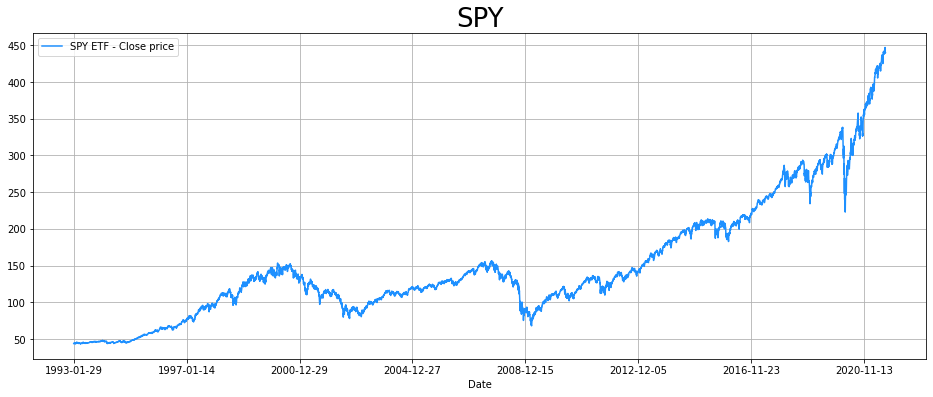

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
df.plot(x='Date', y='Close', color='dodgerblue', label='SPY ETF - Close price', ax=ax)
plt.title('SPY', fontsize=26)
plt.grid()
plt.legend();

In [5]:
df

,Date,Close
0,1993-01-29,43.937500
1,1993-02-01,44.250000
2,1993-02-02,44.343750
3,1993-02-03,44.812500
4,1993-02-04,45.000000
...,...,...
7187,2021-08-13,445.920013
7188,2021-08-16,446.970001
7189,2021-08-17,444.040009
7190,2021-08-18,439.179993


* Now let's set the MA and then Volatility for some number of days, and add the daily Return of the SPY in percentage

In [6]:
yearly_adjust = np.sqrt(252)
hist_periods = [10, 30, 60, 120]
log_return = pd.Series(np.log(df['Close'] / df['Close'].shift(1)))
for period in hist_periods:
    df[f'MA_{period}_days'] = log_return.rolling(period).mean() * yearly_adjust
    df[f'hist_vol_{period}_days'] = log_return.rolling(period).std() * yearly_adjust
df['Return'] = df['Close'].pct_change() * 100
df.fillna(0,inplace=True)
df

,Date,Close,MA_10_days,hist_vol_10_days,MA_30_days,hist_vol_30_days,MA_60_days,hist_vol_60_days,MA_120_days,hist_vol_120_days,Return
0,1993-01-29,43.937500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1993-02-01,44.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.711238
2,1993-02-02,44.343750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.211864
3,1993-02-03,44.812500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.057082
4,1993-02-04,45.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.418410
...,...,...,...,...,...,...,...,...,...,...,...
7187,2021-08-13,445.920013,0.026601,0.060217,0.018708,0.099337,0.021665,0.093842,0.018576,0.125438,0.181984
7188,2021-08-16,446.970001,0.033668,0.056429,0.015923,0.097529,0.019456,0.091833,0.017438,0.124633,0.235466
7189,2021-08-17,444.040009,0.010366,0.060805,0.013408,0.099675,0.017933,0.093130,0.019794,0.119485,-0.655523
7190,2021-08-18,439.179993,0.000723,0.080787,0.005718,0.105031,0.012338,0.094463,0.019022,0.120444,-1.094500


* This is our final DF with all moving average and the Return values

In [7]:
# now we mark the test train randomly

# first we set a global var for year training days
year = 252

# we will set the start data 10 years + all nulls from MA
start_train_idx = 121 + 10*year

# stop for 2 years prior to data ends
stop_train_idx = df.shape[0] - 2*year

# and end index for the ending
end_test_idx = df.shape[0]

* divide the data

In [8]:
train = pd.DataFrame(df, index = range(start_train_idx, stop_train_idx)).reset_index(drop=True)
test = pd.DataFrame(df, index = range(stop_train_idx + 1, end_test_idx)).reset_index(drop=True)

* see the shapes

In [9]:
train.shape, test.shape

((4047, 11), (503, 11))

* Create the model

In [10]:
model = hmm.GaussianHMM(n_components = hidden_states, covariance_type="full", n_iter = em_iterations, random_state=26);

* we will set the Data to be Fitted on the Historical 10 days Volatility and the return.

In [11]:
columns_to_keep = ['Return', 'hist_vol_10_days']
obs = train[columns_to_keep].to_numpy()

* Fitting the model and obtaining predictions

In [12]:
model.fit(obs)
predictions = model.predict(obs)

* now we see the predictions

<Figure size 1152x432 with 0 Axes>

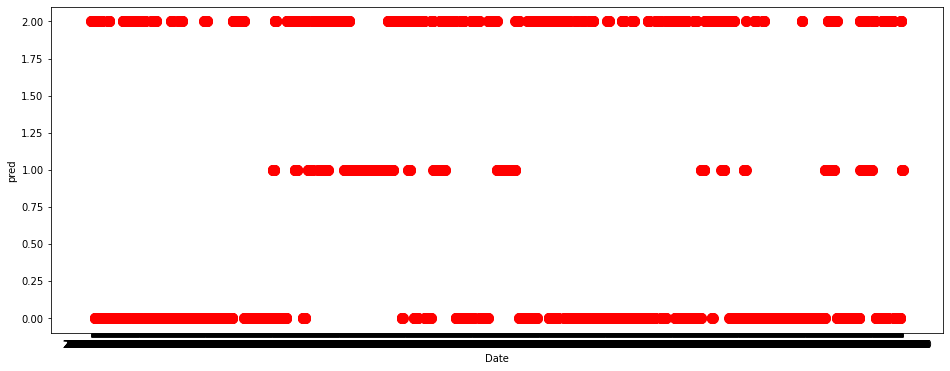

In [13]:
plt.figure(figsize=(16, 6))
#train.assign(pred=predictions).plot(x='Date', y='pred', kind = 'scatter', figsize=(16, 6));
train.assign(pred=predictions).plot.scatter(x='Date', y='pred',s =100, c = 'red', figsize=(16, 6));

* and lets plot the state with regards to the closing 

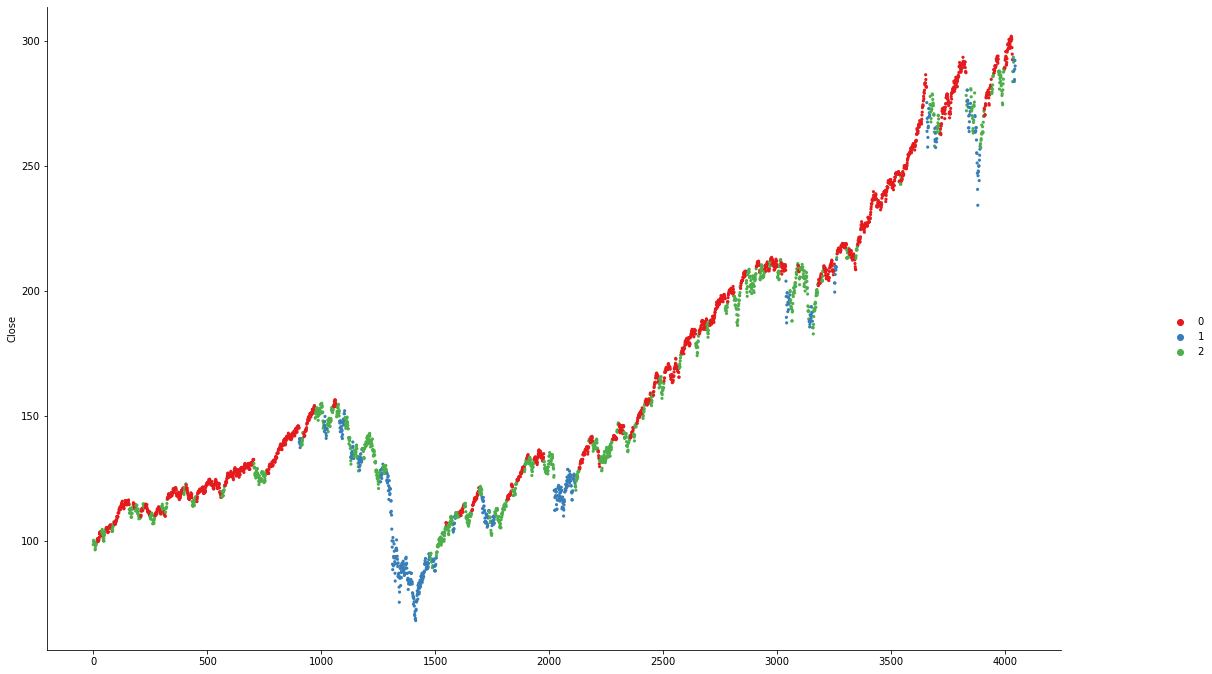

In [14]:
plot = sns.relplot(x=range(0,train.shape[0]), y="Close", data=train, hue=predictions, linewidth = 0, palette="Set1", s = 10);
plot.fig.set_size_inches(18,10)

In [15]:
print("Model Score: {0}".format(model.score(obs)));

Model Score: 2685.784269876875


In [16]:
res_train = deepcopy(train)
res_train['prediction'] = predictions
res_total = res_train[[x for x in columns_to_keep] + ['prediction']].groupby('prediction').mean().reset_index()
res_total

,prediction,Return,hist_vol_10_days
0,0,0.063921,0.082839
1,1,-0.040606,0.346257
2,2,0.016069,0.159298


In [17]:
loser_state = res_total['Return'].argmin()
winner_state = res_total['Return'].argmax()
loser_state, winner_state

(1, 0)

* we can see 1 is the "loser state" (it changes for each iteration...) we will choose the other states 

In [18]:
first_trading = train['Close'].iloc[0]
trading = [first_trading]
for day, (daily_return, prediction) in enumerate(zip(train['Return'][1:], predictions[1:]), start=1):
    trading.append(trading[-1] * (1 + (daily_return / 100 * (prediction != loser_state))))
train['trading_sim'] = trading
train

,Date,Close,MA_10_days,hist_vol_10_days,MA_30_days,hist_vol_30_days,MA_60_days,hist_vol_60_days,MA_120_days,hist_vol_120_days,Return,trading_sim
0,2003-07-24,98.489998,-0.013002,0.144743,-0.009636,0.162325,0.017719,0.155028,0.017847,0.187889,-0.755744,98.489998
1,2003-07-25,100.230003,-0.000158,0.165046,-0.002002,0.170363,0.022927,0.158456,0.019903,0.189382,1.766682,100.230003
2,2003-07-28,99.860001,-0.013770,0.163544,0.001592,0.167892,0.021978,0.158777,0.020724,0.188820,-0.369153,99.860001
3,2003-07-29,99.400002,-0.017629,0.164545,-0.011896,0.156343,0.017011,0.156979,0.020937,0.188698,-0.460644,99.400002
4,2003-07-30,99.160004,-0.012120,0.162636,-0.013175,0.156399,0.016883,0.157021,0.021242,0.188571,-0.241447,99.160004
...,...,...,...,...,...,...,...,...,...,...,...,...
4042,2019-08-14,283.899994,-0.073907,0.277827,-0.022853,0.172750,-0.000047,0.149935,0.002237,0.131500,-2.956758,426.407450
4043,2019-08-15,284.649994,-0.055835,0.279009,-0.025671,0.170911,-0.001723,0.148873,0.002406,0.131538,0.264178,426.407450
4044,2019-08-16,288.850006,-0.020585,0.291971,-0.017318,0.177300,0.002966,0.151767,0.004438,0.133197,1.475500,426.407450
4045,2019-08-19,292.329987,0.046898,0.247353,-0.008066,0.180722,0.009387,0.151392,0.006079,0.134266,1.204771,426.407450


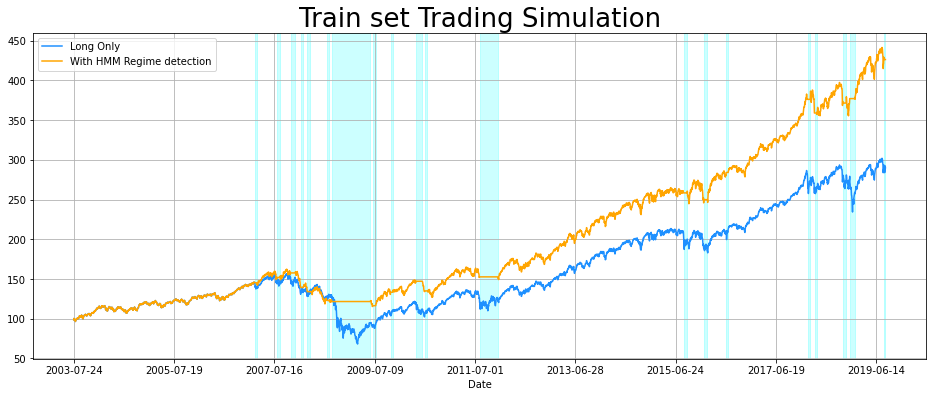

For the buy and hold trading strategy => Overall return = 194.54%  ~  Yearly return = 6.95%  ~  Z-score = 1.859
For the HMM based    trading strategy => Overall return = 332.94%  ~  Yearly return = 9.54%  ~  Z-score = 3.481


(array([1.85886978]), array([3.4806954]))

In [19]:
graph_prediction(predictions, train, loser_state, 'Train')

We see that our model managed to detect some periods of bear market, and overall it has a significantly better return than the Long-Only model!<br>
It has also a Z-score almost twice as good, which means it seems valuable!

# Now let's test the model on the test data !

In [20]:
obs_test = test[columns_to_keep].to_numpy()
obs_test

array([[-0.03078372,  0.22597074],
       [-2.5687438 ,  0.25927475],
       [ 1.10584305,  0.26068037],
       ...,
       [-0.65552319,  0.06080486],
       [-1.09449957,  0.08078669],
       [ 0.15483219,  0.07366273]])

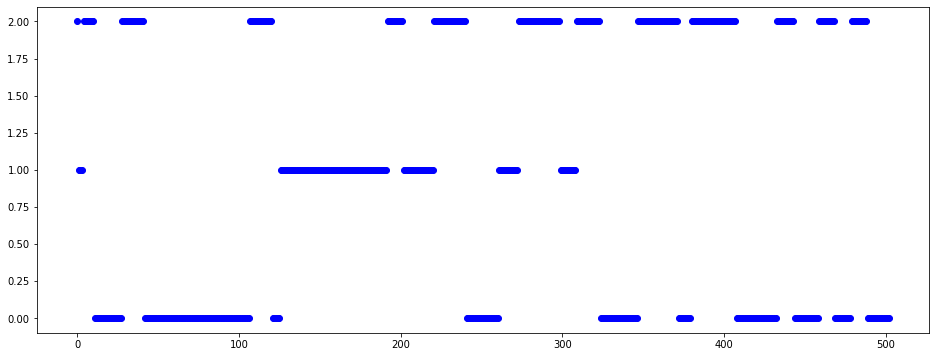

In [21]:
predictions_test = model.predict(obs_test)
plt.figure(figsize=(16, 6))
plt.plot(predictions_test, 'bo');

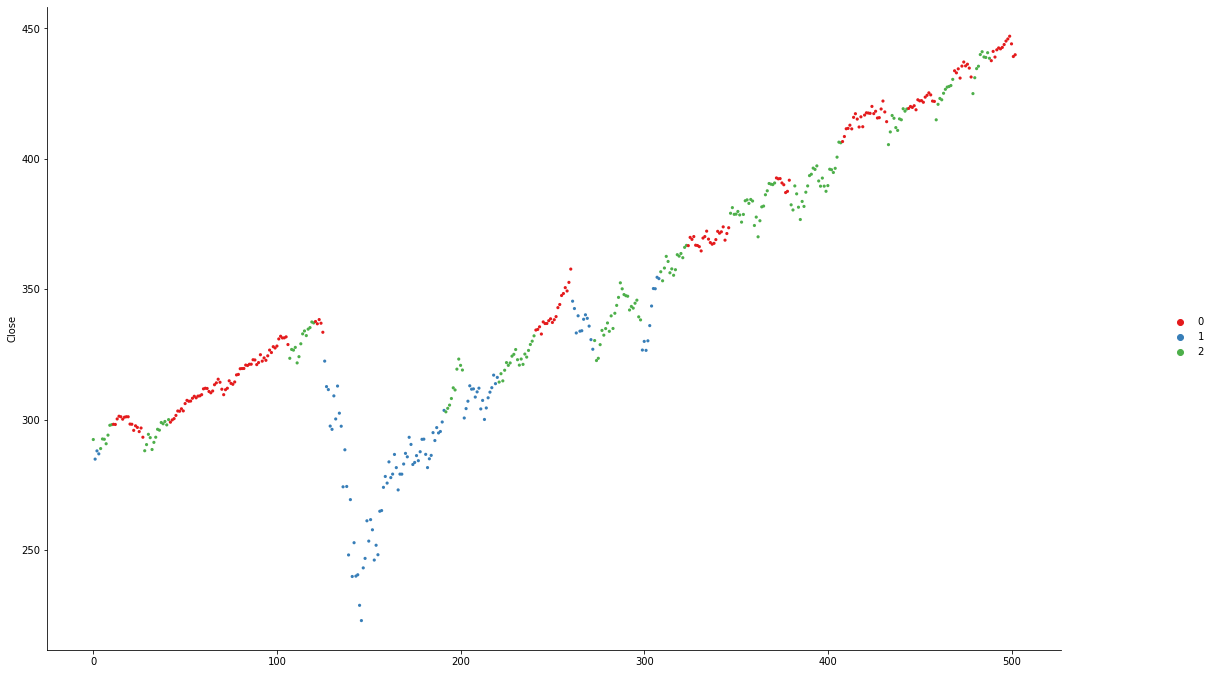

In [22]:
plot = sns.relplot(x=range(0,test.shape[0]), y="Close", data=test, hue=predictions_test, linewidth = 0, palette="Set1", s = 10);
plot.fig.set_size_inches(18,10)


In [23]:
print("Model Score: {0}".format(model.score(obs)));

Model Score: 2685.784269876875


In [24]:
first_trading_test = test['Close'].iloc[0]
trading_test = [first_trading_test]
for day, (daily_return, prediction) in enumerate(zip(test['Return'][1:], predictions_test[1:]), start=1):
    trading_test.append(trading_test[-1] * (1 + (daily_return / 100 * (prediction != loser_state))))
test['trading_sim'] = trading_test
test

,Date,Close,MA_10_days,hist_vol_10_days,MA_30_days,hist_vol_30_days,MA_60_days,hist_vol_60_days,MA_120_days,hist_vol_120_days,Return,trading_sim
0,2019-08-22,292.359985,-0.006827,0.225971,-0.012432,0.182743,0.013068,0.150932,0.005998,0.134816,-0.030784,292.359985
1,2019-08-23,284.850006,-0.037287,0.259275,-0.028566,0.196015,0.005462,0.160575,0.002736,0.140122,-2.568744,292.359985
2,2019-08-26,288.000000,-0.000386,0.260680,-0.022922,0.199431,0.011961,0.159373,0.004994,0.140693,1.105843,292.359985
3,2019-08-27,286.869995,-0.031124,0.246257,-0.023293,0.199495,0.011594,0.159521,0.005585,0.140255,-0.392363,292.359985
4,2019-08-28,288.890015,0.027660,0.192419,-0.015967,0.200297,0.007769,0.154152,0.006778,0.140543,0.704159,294.418663
...,...,...,...,...,...,...,...,...,...,...,...,...
498,2021-08-13,445.920013,0.026601,0.060217,0.018708,0.099337,0.021665,0.093842,0.018576,0.125438,0.181984,526.468320
499,2021-08-16,446.970001,0.033668,0.056429,0.015923,0.097529,0.019456,0.091833,0.017438,0.124633,0.235466,527.707971
500,2021-08-17,444.040009,0.010366,0.060805,0.013408,0.099675,0.017933,0.093130,0.019794,0.119485,-0.655523,524.248723
501,2021-08-18,439.179993,0.000723,0.080787,0.005718,0.105031,0.012338,0.094463,0.019022,0.120444,-1.094500,518.510823


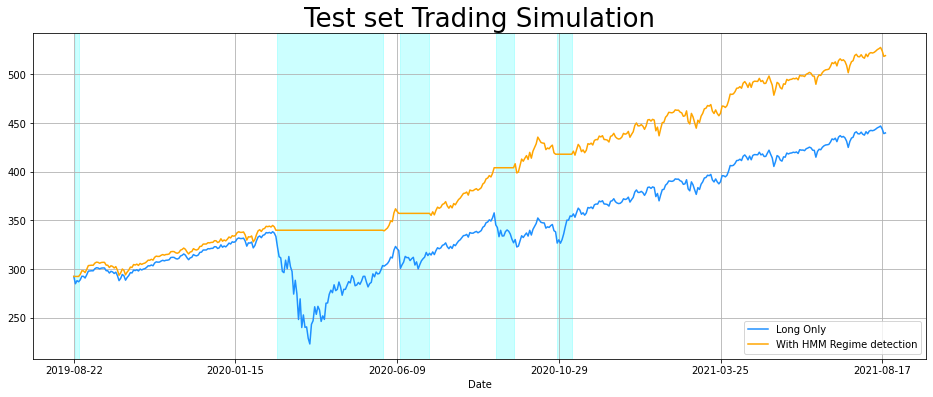

For the buy and hold trading strategy => Overall return = 50.45%  ~  Yearly return = 22.73%  ~  Z-score = 1.328
For the HMM based    trading strategy => Overall return = 77.63%  ~  Yearly return = 33.38%  ~  Z-score = 3.838


(array([1.32839086]), array([3.83814629]))

In [25]:
graph_prediction(predictions_test, test, loser_state, 'Test')

Wow... This result just seems to be too good to be true... Are we on the path to the Fortune?... Or did we make a mistake with our data?....

Let's have a closer look at our data...<br>
According to the documentation of hmmlearn, the 'predict' function findd most likely state sequence corresponding to the observed states... In other words, when we gave the model the observed outputs, we got the estimated states at each step... But we cannot do Back-trading based on the whole picture!! We need to do a 'predict' step by step based only on the path *before* the prediction time... Let's do it now...

In [26]:
predictions_list = []
predictions_list_all = []
for i, index in enumerate(obs_test):
    this_predict = model.predict(np.vstack((obs, obs_test[:i])))
    predictions_list.append(this_predict[-1])
    predictions_list_all.append(this_predict.tolist() + [this_predict[-1]] * (len(obs_test) - i))

In [27]:
len(predictions_list_all)

503

In [28]:
test['trading_sim_leaked_data'] = test['trading_sim']

first_trading_test = test['Close'].iloc[0]
trading_test = [first_trading_test]
for day, (daily_return, prediction) in enumerate(zip(test['Return'][1:], predictions_list[1:]), start=1):
    trading_test.append(trading_test[-1] * (1 + (daily_return / 100 * (prediction != loser_state))))
test['trading_sim'] = trading_test
test

,Date,Close,MA_10_days,hist_vol_10_days,MA_30_days,hist_vol_30_days,MA_60_days,hist_vol_60_days,MA_120_days,hist_vol_120_days,Return,trading_sim,trading_sim_leaked_data
0,2019-08-22,292.359985,-0.006827,0.225971,-0.012432,0.182743,0.013068,0.150932,0.005998,0.134816,-0.030784,292.359985,292.359985
1,2019-08-23,284.850006,-0.037287,0.259275,-0.028566,0.196015,0.005462,0.160575,0.002736,0.140122,-2.568744,292.359985,292.359985
2,2019-08-26,288.000000,-0.000386,0.260680,-0.022922,0.199431,0.011961,0.159373,0.004994,0.140693,1.105843,292.359985,292.359985
3,2019-08-27,286.869995,-0.031124,0.246257,-0.023293,0.199495,0.011594,0.159521,0.005585,0.140255,-0.392363,292.359985,292.359985
4,2019-08-28,288.890015,0.027660,0.192419,-0.015967,0.200297,0.007769,0.154152,0.006778,0.140543,0.704159,292.359985,294.418663
...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,2021-08-13,445.920013,0.026601,0.060217,0.018708,0.099337,0.021665,0.093842,0.018576,0.125438,0.181984,436.205993,526.468320
499,2021-08-16,446.970001,0.033668,0.056429,0.015923,0.097529,0.019456,0.091833,0.017438,0.124633,0.235466,437.233108,527.707971
500,2021-08-17,444.040009,0.010366,0.060805,0.013408,0.099675,0.017933,0.093130,0.019794,0.119485,-0.655523,434.366944,524.248723
501,2021-08-18,439.179993,0.000723,0.080787,0.005718,0.105031,0.012338,0.094463,0.019022,0.120444,-1.094500,429.612799,518.510823


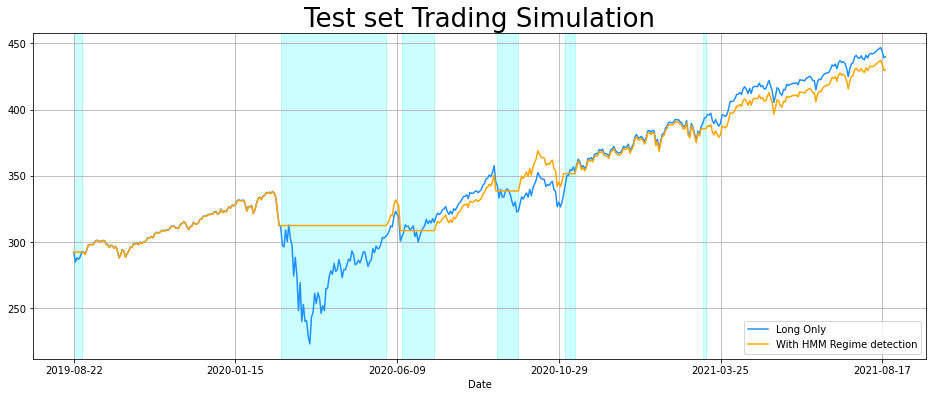

For the buy and hold trading strategy => Overall return = 50.45%  ~  Yearly return = 22.73%  ~  Z-score = 1.328
For the HMM based    trading strategy => Overall return = 47.17%  ~  Yearly return = 21.38%  ~  Z-score = 2.296


(array([1.32839086]), array([2.29566462]))

In [29]:
graph_prediction(predictions_list, test, loser_state, 'Test')

Back on earth... Our HMM could not achieve (at this stage...) a better overall return than the Long-Only strategy...<br>
BUT it did achieve a better Z-score than the Long-Only, meaning the volatility of the HMM based strategy was significantly lower than the volatility of the Buy and Hold strategy, which is highly valuable!

We would like to check now if there were many events of prediction change backwards.

In [30]:
nb_lines, sanity_check, nb_cols = len(predictions_list_all[0]), len(predictions_list_all[-1]), len(predictions_list_all)
nb_lines, sanity_check, nb_cols

(4550, 4550, 503)

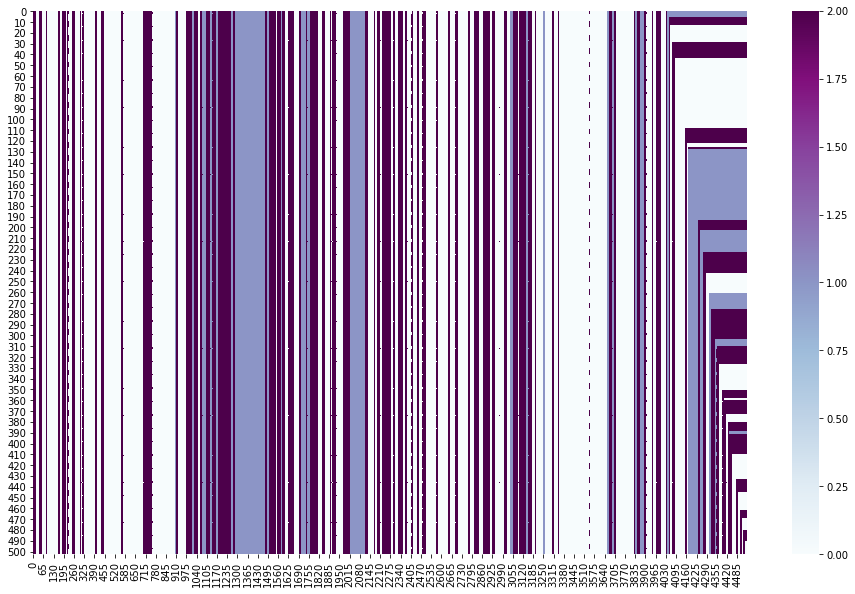

In [31]:
plt.figure(figsize=(16, 10))
sns.heatmap(np.array(predictions_list_all), cmap="BuPu");

We would like to check if there was any change in the "predict" of the model on the train set. Let's have a look!

In [32]:
pred_df = pd.DataFrame(np.array(predictions_list_all).T)
set(pred_df.iloc[:4047, :].sum(axis='columns') % 503)

{0}

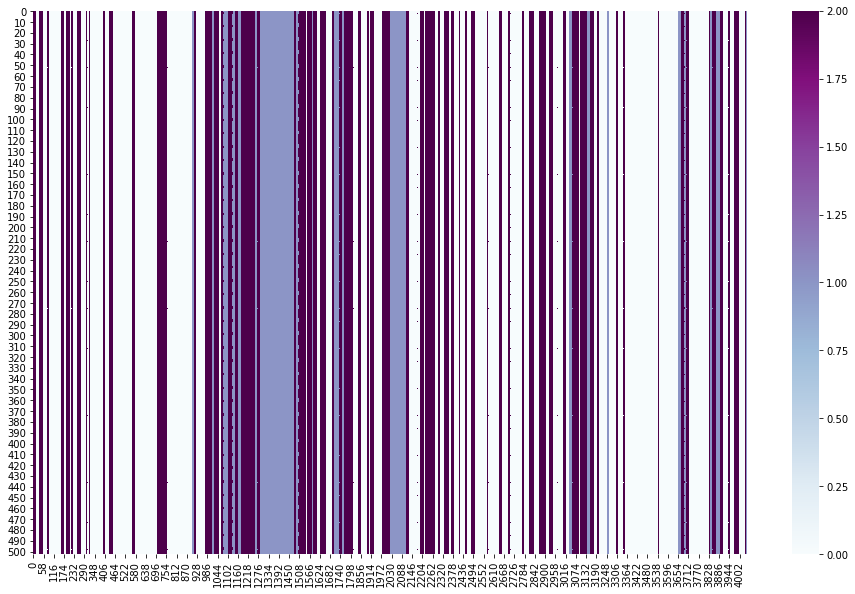

In [33]:
plt.figure(figsize=(16, 10))
sns.heatmap(np.array(predictions_list_all)[:, :4047], cmap="BuPu");

We can see that there was no change at all. The way we checked it is as follows: For each point in the observation_test we run a "predict" on the whole series of data, including the initial train set (obs) and an increasing number of points from the test set. Then we stack all these predictions, just keeping the last point and copying it to the end (to have the same number of points for all the predictions). Eventually, I draw a heatmap of all the predictions, to see if all the points predicted for the train and test sets are predicted the same.<br>
Moreover, on the train set we sum all the columns numbers and compute modulo 503 (the number of test points) to check if there were some different predictions in the train set for different numbers of added test points. And we got 0 ! Meaning for all the steps of the test set prediction, we had 503 times the exact same Hidden State prediction for each point of the train set!

Let's have a closer look at the test set now.

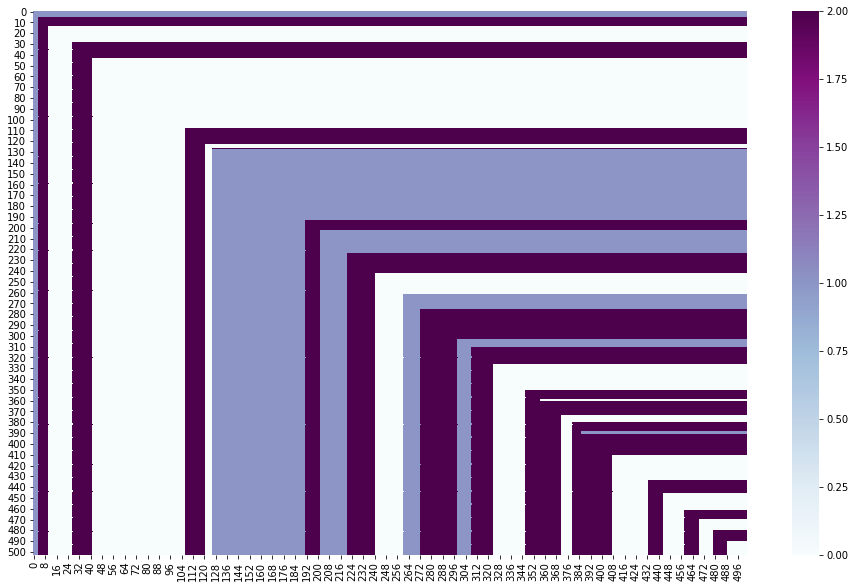

In [34]:
plt.figure(figsize=(16, 10))
sns.heatmap(np.array(predictions_list_all)[:, 4047:], cmap="BuPu");

This looks like psychedelic... But we can see here that there are at least 3 times for which the prediction for the point t will eventually be overriden later when further points will be available... <br>
Let's have a look at the numbers.

In [35]:
test_predict = np.array(predictions_list_all)[:, -503:]
test_predict.shape

(503, 503)

In [36]:
for i in range(test_predict.shape[0] - 1):
    if len(set(test_predict[i+1:, i].tolist())) > 1:
        print(f'There is a prediction override for the test point {i} !!')

There is a prediction override for the test point 4 !!
There is a prediction override for the test point 11 !!
There is a prediction override for the test point 12 !!
There is a prediction override for the test point 42 !!
There is a prediction override for the test point 107 !!
There is a prediction override for the test point 121 !!
There is a prediction override for the test point 126 !!
There is a prediction override for the test point 192 !!
There is a prediction override for the test point 221 !!
There is a prediction override for the test point 222 !!
There is a prediction override for the test point 241 !!
There is a prediction override for the test point 273 !!
There is a prediction override for the test point 274 !!
There is a prediction override for the test point 299 !!
There is a prediction override for the test point 300 !!
There is a prediction override for the test point 301 !!
There is a prediction override for the test point 302 !!
There is a prediction override for t

# Encapsulating the model

Now let's package the whole model and run it on several other columns

In [37]:
def run_hmm_model(df_train, df_test, keep_columns):
    """
    This function will do the whole job for a given subset of columns:
    1- Initiate the HMM model and fit it to the TRAIN dataframe
    2- Plot a graph of the regimes and the Asset with regime color
    3- Calculate the Model Score
    4- Display the winner / loser / average states
    5- Display states, simulate Trading and Graph Predictions of the HMM model on TRAIN SET
    6- Define TEST SET and generate step-by-step predictions
    7- Display states, simulate Trading and Graph Predictions of the HMM model on TEST SET
    """
    
    # define the reduced DataFrame and train the model
    this_train = deepcopy(df_train)
    this_obs = this_train[keep_columns].to_numpy()
    this_model = hmm.GaussianHMM(n_components = hidden_states, covariance_type="full", n_iter = em_iterations, random_state=26)
    this_model.fit(this_obs)
    this_predictions = this_model.predict(this_obs)
    print('\n')
    
    # Plot the regimes path and the colorful Index points
    plt.figure(figsize=(16, 6))
    plt.plot(this_predictions, 'bo')
    plt.title('Path to Regimes')
    plt.show()
    plot = sns.relplot(x=range(0,df_train.shape[0]), y="Close", data=df_train, hue=this_predictions, linewidth = 0, palette="Set1", s = 10);
    plot.fig.set_size_inches(18,10)
    plot.fig.suptitle('SPY ETF with relevant regime')
    plt.show()
    print('\n')
    
    # Print model score
    print("Model Score: {0}".format(this_model.score(this_obs)));
    
    # Display states
    this_res_train = deepcopy(df_train)
    this_res_train['prediction'] = this_predictions
    this_res_total = this_res_train[[x for x in keep_columns] + ['prediction']].groupby('prediction').mean().reset_index()
    display(this_res_total)
    
    this_loser_state = this_res_total['Return'].argmin()
    this_winner_state = this_res_total['Return'].argmax()
    this_loser_state, this_winner_state
    print(f'The Winner State is: {this_winner_state} / The Loser State is: {this_loser_state}')
    
    # Display states and simulate Trading
    this_first_trading = df_train['Close'].iloc[0]
    this_trading = [this_first_trading]
    for day, (daily_return, prediction) in enumerate(zip(df_train['Return'][1:], this_predictions[1:]), start=1):
        this_trading.append(this_trading[-1] * (1 + (daily_return / 100 * (prediction != this_loser_state))))
    this_train['trading_sim'] = this_trading
    display(this_train)
    
    # Graph Predictions on TRAIN SET
    graph_prediction(this_predictions, this_train, this_loser_state, 'Train')
    
    # Define TEST SET and generate predictions
    this_test = deepcopy(df_test)
    this_obs_test = this_test[keep_columns].to_numpy()
    this_predictions_list = []
    this_predictions_list_all = []
    for i, index in enumerate(this_obs_test):
        this_predict = this_model.predict(np.vstack((this_obs, this_obs_test[:i])))
        this_predictions_list.append(this_predict[-1])
        this_predictions_list_all.append(this_predict.tolist() + [this_predict[-1]] * (len(this_obs_test) - i))
        
    # Display states and simulate Trading
    this_first_trading_test = df_test['Close'].iloc[0]
    this_trading_test = [this_first_trading_test]
    this_predictions_test = np.array(this_predictions_list)
    for day, (daily_return, prediction) in enumerate(zip(df_test['Return'][1:], this_predictions_test[1:]), start=1):
        this_trading_test.append(this_trading_test[-1] * (1 + (daily_return / 100 * (prediction != this_loser_state) * (1 + 0 * (prediction == this_winner_state)))))
    this_test['trading_sim'] = this_trading_test

    graph_prediction(this_predictions_list, this_test, this_loser_state, 'Test')

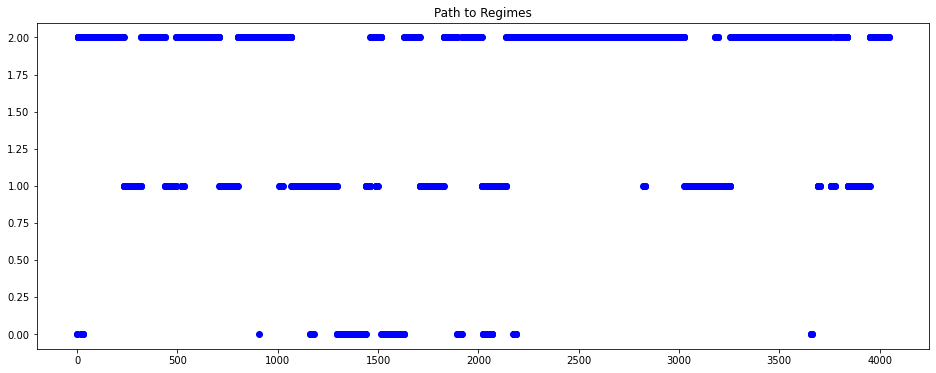

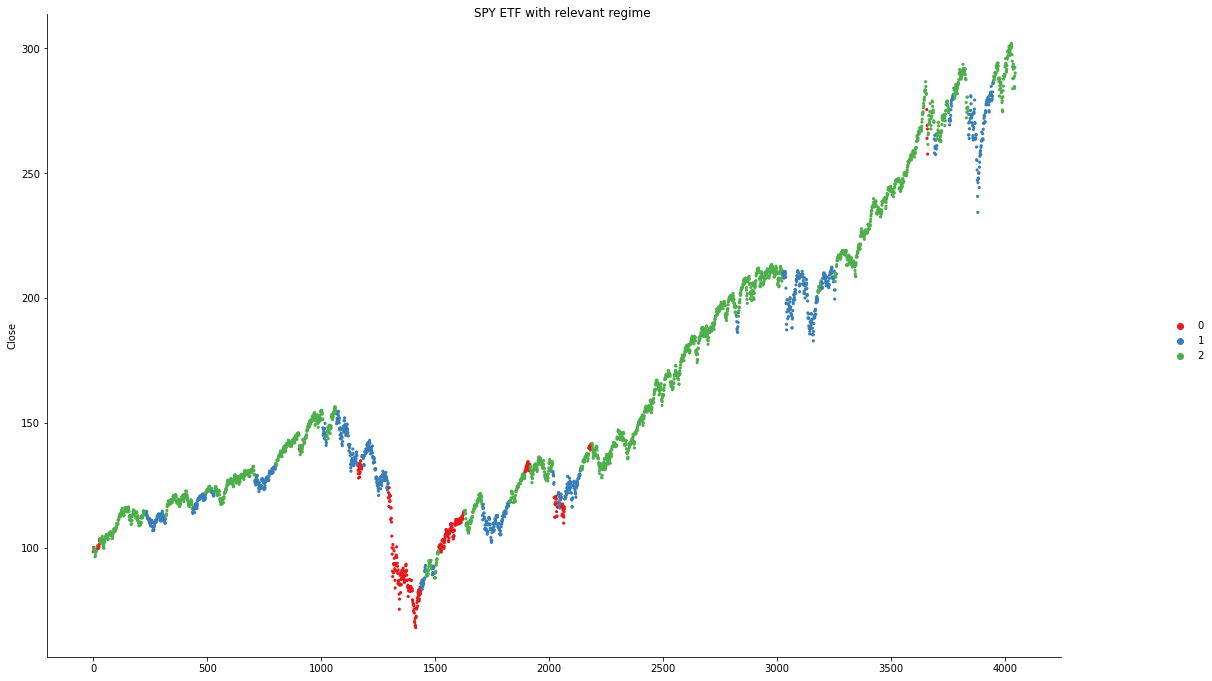



Model Score: 9268.490713801106


,prediction,Return,MA_120_days
0,0,-0.050933,-0.009469
1,1,-0.009048,-0.004106
2,2,0.062037,0.010034


The Winner State is: 2 / The Loser State is: 0


,Date,Close,MA_10_days,hist_vol_10_days,MA_30_days,hist_vol_30_days,MA_60_days,hist_vol_60_days,MA_120_days,hist_vol_120_days,Return,trading_sim
0,2003-07-24,98.489998,-0.013002,0.144743,-0.009636,0.162325,0.017719,0.155028,0.017847,0.187889,-0.755744,98.489998
1,2003-07-25,100.230003,-0.000158,0.165046,-0.002002,0.170363,0.022927,0.158456,0.019903,0.189382,1.766682,98.489998
2,2003-07-28,99.860001,-0.013770,0.163544,0.001592,0.167892,0.021978,0.158777,0.020724,0.188820,-0.369153,98.126419
3,2003-07-29,99.400002,-0.017629,0.164545,-0.011896,0.156343,0.017011,0.156979,0.020937,0.188698,-0.460644,97.674406
4,2003-07-30,99.160004,-0.012120,0.162636,-0.013175,0.156399,0.016883,0.157021,0.021242,0.188571,-0.241447,97.438574
...,...,...,...,...,...,...,...,...,...,...,...,...
4042,2019-08-14,283.899994,-0.073907,0.277827,-0.022853,0.172750,-0.000047,0.149935,0.002237,0.131500,-2.956758,380.811999
4043,2019-08-15,284.649994,-0.055835,0.279009,-0.025671,0.170911,-0.001723,0.148873,0.002406,0.131538,0.264178,381.818019
4044,2019-08-16,288.850006,-0.020585,0.291971,-0.017318,0.177300,0.002966,0.151767,0.004438,0.133197,1.475500,387.451745
4045,2019-08-19,292.329987,0.046898,0.247353,-0.008066,0.180722,0.009387,0.151392,0.006079,0.134266,1.204771,392.119652


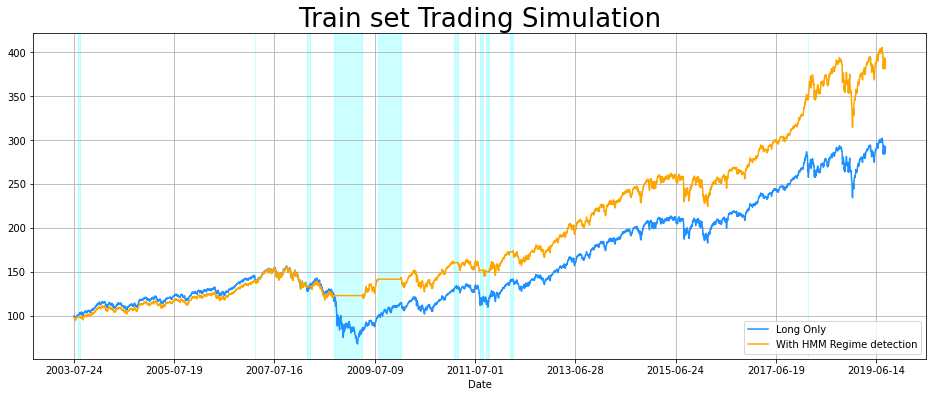

For the buy and hold trading strategy => Overall return = 194.54%  ~  Yearly return = 6.95%  ~  Z-score = 1.859
For the HMM based    trading strategy => Overall return = 295.08%  ~  Yearly return = 8.92%  ~  Z-score = 2.848


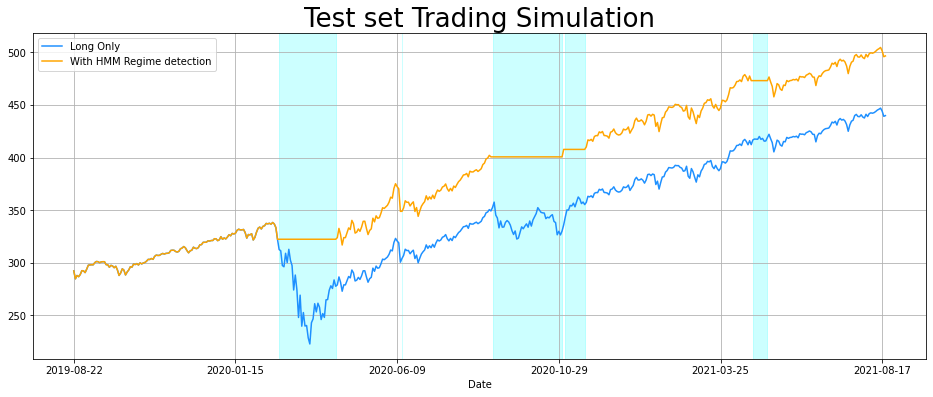

For the buy and hold trading strategy => Overall return = 50.45%  ~  Yearly return = 22.73%  ~  Z-score = 1.328
For the HMM based    trading strategy => Overall return = 69.85%  ~  Yearly return = 30.42%  ~  Z-score = 2.941


In [38]:
columns_to_remove = ['Date', 'Close']
columns_to_keep = [x for x in train.columns if x not in columns_to_remove]
columns_to_keep = ['Return', 'MA_120_days']
run_hmm_model(train, test, columns_to_keep)

Wow again!! This seems to be for real now !
In this function we perform the whole process on some selected columns, and assess the results on the test set. When we run our HMM model on the 'Return' and 'MA_120_days' (the moving average of the return on 120 days) and we got outstanding results!

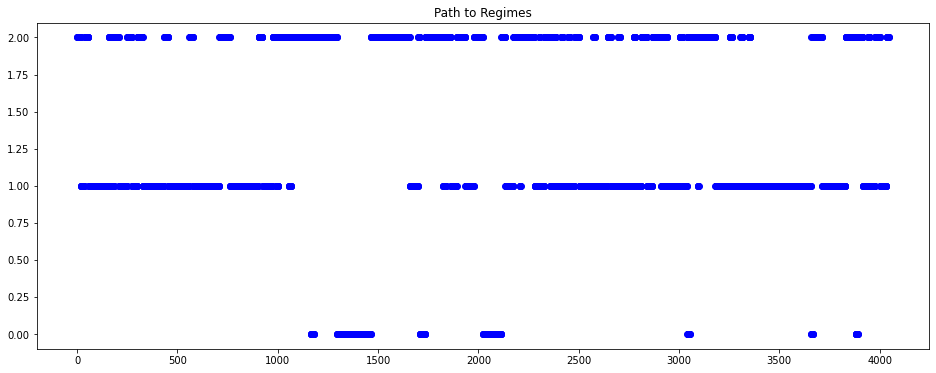

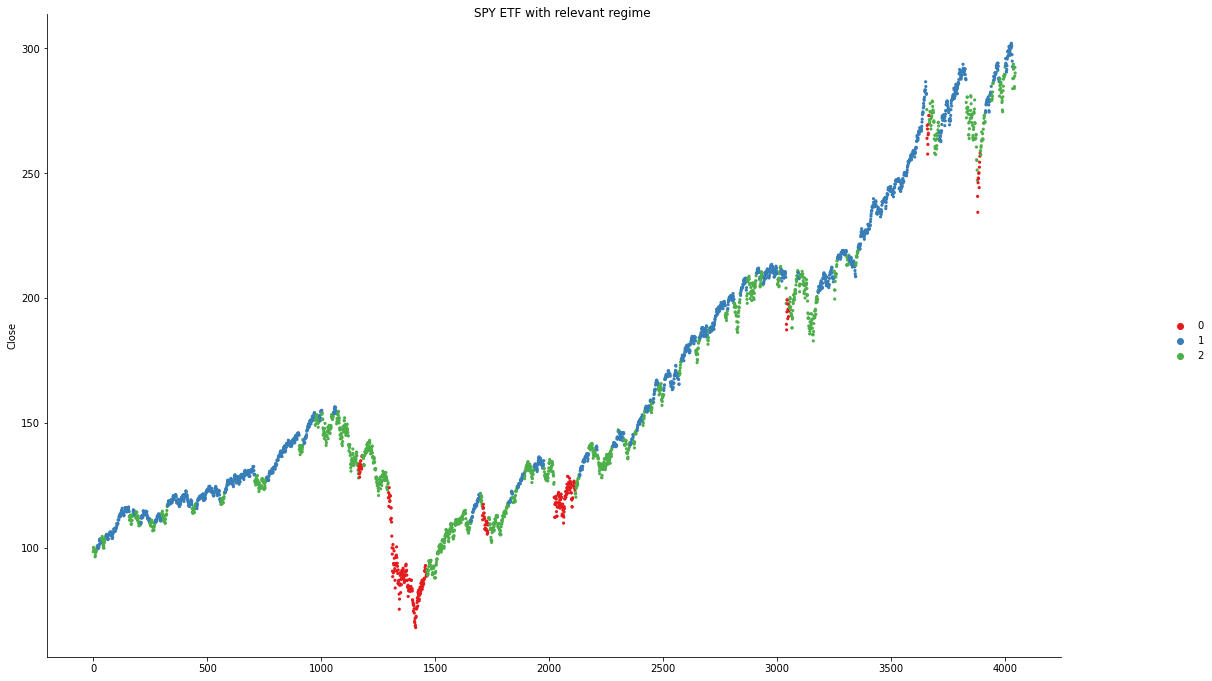



Model Score: 24182.099805373313


,prediction,Return,MA_120_days,MA_10_days,hist_vol_10_days
0,0,-0.048229,-0.025948,-0.028406,0.410022
1,1,0.067695,0.009056,0.014421,0.083840
2,2,0.004970,0.005062,-0.002200,0.169928


The Winner State is: 1 / The Loser State is: 0


,Date,Close,MA_10_days,hist_vol_10_days,MA_30_days,hist_vol_30_days,MA_60_days,hist_vol_60_days,MA_120_days,hist_vol_120_days,Return,trading_sim
0,2003-07-24,98.489998,-0.013002,0.144743,-0.009636,0.162325,0.017719,0.155028,0.017847,0.187889,-0.755744,98.489998
1,2003-07-25,100.230003,-0.000158,0.165046,-0.002002,0.170363,0.022927,0.158456,0.019903,0.189382,1.766682,100.230003
2,2003-07-28,99.860001,-0.013770,0.163544,0.001592,0.167892,0.021978,0.158777,0.020724,0.188820,-0.369153,99.860001
3,2003-07-29,99.400002,-0.017629,0.164545,-0.011896,0.156343,0.017011,0.156979,0.020937,0.188698,-0.460644,99.400002
4,2003-07-30,99.160004,-0.012120,0.162636,-0.013175,0.156399,0.016883,0.157021,0.021242,0.188571,-0.241447,99.160004
...,...,...,...,...,...,...,...,...,...,...,...,...
4042,2019-08-14,283.899994,-0.073907,0.277827,-0.022853,0.172750,-0.000047,0.149935,0.002237,0.131500,-2.956758,382.599983
4043,2019-08-15,284.649994,-0.055835,0.279009,-0.025671,0.170911,-0.001723,0.148873,0.002406,0.131538,0.264178,383.610726
4044,2019-08-16,288.850006,-0.020585,0.291971,-0.017318,0.177300,0.002966,0.151767,0.004438,0.133197,1.475500,389.270904
4045,2019-08-19,292.329987,0.046898,0.247353,-0.008066,0.180722,0.009387,0.151392,0.006079,0.134266,1.204771,393.960727


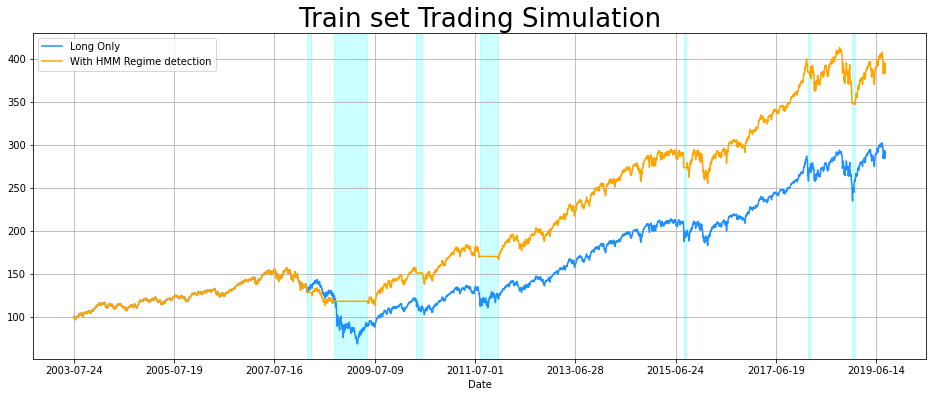

For the buy and hold trading strategy => Overall return = 194.54%  ~  Yearly return = 6.95%  ~  Z-score = 1.859
For the HMM based    trading strategy => Overall return = 296.94%  ~  Yearly return = 8.95%  ~  Z-score = 2.997


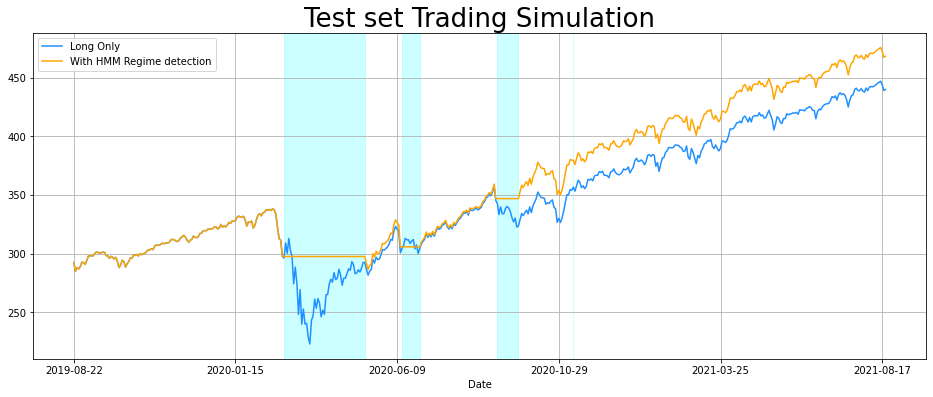

For the buy and hold trading strategy => Overall return = 50.45%  ~  Yearly return = 22.73%  ~  Z-score = 1.328
For the HMM based    trading strategy => Overall return = 60.13%  ~  Yearly return = 26.62%  ~  Z-score = 2.504


In [39]:
columns_to_keep = ['Return', 'MA_120_days', 'MA_10_days', 'hist_vol_10_days']
run_hmm_model(train, test, columns_to_keep)

# Using Validation Set

Now we build our model again but with a validation phase:<br>
We will split our data to Train / Validation (500 points) / Test (500 points) and run a fit on the Train Set and a Predict on the Validation Set for each possible column (along with the 'Return' column). Then we will chose the best feature, based on the best Z_Score for the Validation Set, and run a Predict on the Test Set to check the performance...

In [44]:
def run_hmm_model_valid(df):
    """
    This function will do the whole job for a given subset of columns:
    1- Initiate the HMM model and fit it to the TRAIN dataframe
    2- Plot a graph of the regimes and the Asset with regime color
    3- Calculate the Model Score
    4- Display the winner / loser / average states
    5- Display states, simulate Trading and Graph Predictions of the HMM model on TRAIN SET
    6- Define TEST SET and generate step-by-step predictions
    7- Display states, simulate Trading and Graph Predictions of the HMM model on TEST SET
    """
    
    # define the reduced DataFrame and train the model
    assert len(df.columns) == 1
    assert df.columns == 'Close'
    
    yearly_adjust = np.sqrt(252)
    hist_periods = [15, 30, 60, 120]
    log_return = pd.Series(np.log(df['Close'] / df['Close'].shift(1)))
    for period in hist_periods:
        df[f'MA_{period}_days'] = log_return.rolling(period).mean() * yearly_adjust
        df[f'hist_vol_{period}_days'] = log_return.rolling(period).std() * yearly_adjust
    df['Return'] = df['Close'].pct_change() * 100
    df.dropna(axis=0, inplace=True)
    
    start_index = np.where(testDf.index == '2003-07-01')[0][0]
    df = df.iloc[start_index:]
    df_train, df_valid, df_test = df.iloc[:-1000], df.iloc[-1000:-500], df.iloc[-500:]
    # return {'df_train': df_train, 'df_valid': df_valid, 'df_test': df_test}
    # return df
    
    all_fields = [x for x in df_train.columns if x not in ['Close', 'Return']]
    #all_fields = [x for x in all_fields if 'hist_vol' in x]
    
    all_z_scores = dict()
    all_models = dict()
    for field in all_fields:

        print(f'\nNOW USING {field} ....')
        # define the reduced DataFrame and train the model
        keep_columns = ['Return']
        keep_columns.append(field)
        this_train = deepcopy(df_train)
        this_obs = this_train[keep_columns].to_numpy()
        this_model = hmm.GaussianHMM(n_components = hidden_states, covariance_type="full", n_iter = em_iterations, random_state=26)
        this_model.fit(this_obs)
        this_predictions = this_model.predict(this_obs)
        print('\n')

        # Plot the regimes path and the colorful Index points
        plt.figure(figsize=(16, 6))
        plt.plot(this_predictions, 'bo')
        plt.title('Path to Regimes')
        plt.show()
        plot = sns.relplot(x=range(0,df_train.shape[0]), y="Close", data=df_train, hue=this_predictions, linewidth = 0, palette="Set1", s = 10);
        plot.fig.set_size_inches(18,10)
        plot.fig.suptitle('SPY ETF with relevant regime')
        plt.show()
        print('\n')

        # Print model score
        print("Model Score: {0}".format(this_model.score(this_obs)));

        # Display states
        this_res_train = deepcopy(df_train)
        this_res_train['prediction'] = this_predictions
        this_res_total = this_res_train[[x for x in keep_columns] + ['prediction']].groupby('prediction').mean().reset_index()
        display(this_res_total)

        this_loser_state = this_res_total['Return'].argmin()
        this_winner_state = this_res_total['Return'].argmax()
        this_loser_state, this_winner_state
        print(f'The Winner State is: {this_winner_state} / The Loser State is: {this_loser_state}')

        # Display states and simulate Trading
        this_first_trading = df_train['Close'].iloc[0]
        this_trading = [this_first_trading]
        for day, (daily_return, prediction) in enumerate(zip(df_train['Return'][1:], this_predictions[1:]), start=1):
            this_trading.append(this_trading[-1] * (1 + (daily_return / 100 * (prediction != this_loser_state))))
        this_train['trading_sim'] = this_trading
        #display(this_train)

        # Graph Predictions on TRAIN SET
        graph_prediction(this_predictions, this_train, this_loser_state, 'Train')

        # Define VALID SET and generate predictions
        this_valid = deepcopy(df_valid)
        this_obs_valid = this_valid[keep_columns].to_numpy()
        this_predictions_list = []
        this_predictions_list_all = []
        for i, index in enumerate(this_obs_valid):
            this_predict = this_model.predict(np.vstack((this_obs, this_obs_valid[:i])))
            this_predictions_list.append(this_predict[-1])
            this_predictions_list_all.append(this_predict.tolist() + [this_predict[-1]] * (len(this_obs_valid) - i))

        # Display states and simulate Trading
        this_first_trading_valid = df_valid['Close'].iloc[0]
        this_trading_valid = [this_first_trading_valid]
        this_predictions_valid = np.array(this_predictions_list)
        for day, (daily_return, prediction) in enumerate(zip(df_valid['Return'][1:], this_predictions_valid[1:]), start=1):
            this_trading_valid.append(this_trading_valid[-1] * (1 + (daily_return / 100 * (prediction != this_loser_state) * (1 + 0 * (prediction == this_winner_state)))))
        this_valid['trading_sim'] = this_trading_valid

        z_score_train, z_score_valid = graph_prediction(this_predictions_list, this_valid, this_loser_state, 'Valid')
        
        all_z_scores[field] = {'z_score_train': z_score_train, 'z_score_valid': z_score_valid}
        all_models[field] = {'this_model': this_model, 'this_loser_state': this_loser_state, 'this_winner_state': this_winner_state}
        
    # Find best column based on Validation Z_Score
    
    results = {k:v['z_score_valid'][0] for k, v in all_z_scores.items()}
    best_column = max(results, key=results.get)
    print(f'\n\nWE WILL KEEP THE MODEL BASED ON {best_column}, HAVING THE BEST Z_SCORE: {results[best_column]:0.3f} ON THE VALIDATION SET')
    field = best_column
    keep_columns = ['Return']
    keep_columns.append(field)
    this_model = all_models[field]['this_model']
    this_loser_state = all_models[field]['this_loser_state']
    this_winner_state = all_models[field]['this_winner_state']

    # Define TEST SET and generate predictions
    this_test = deepcopy(df_test)
    this_obs_test = this_test[keep_columns].to_numpy()
    this_predictions_list = []
    this_predictions_list_all = []
    for i, index in enumerate(this_obs_test):
        this_predict = this_model.predict(np.vstack((this_obs, this_obs_test[:i])))
        this_predictions_list.append(this_predict[-1])
        this_predictions_list_all.append(this_predict.tolist() + [this_predict[-1]] * (len(this_obs_test) - i))

    # Display states and simulate Trading
    this_first_trading_test = df_test['Close'].iloc[0]
    this_trading_test = [this_first_trading_test]
    this_predictions_test = np.array(this_predictions_list)
    for day, (daily_return, prediction) in enumerate(zip(df_test['Return'][1:], this_predictions_test[1:]), start=1):
        this_trading_test.append(this_trading_test[-1] * (1 + (daily_return / 100 * (prediction != this_loser_state) * (1 + 0 * (prediction == this_winner_state)))))
    this_test['trading_sim'] = this_trading_test

    graph_prediction(this_predictions_list, this_test, this_loser_state, 'Test')


In [45]:
testDf = pd.DataFrame({'Close': df['Close'].to_list()}, index=df['Date'].to_list())
testDf

,Close
1993-01-29,43.937500
1993-02-01,44.250000
1993-02-02,44.343750
1993-02-03,44.812500
1993-02-04,45.000000
...,...
2021-08-13,445.920013
2021-08-16,446.970001
2021-08-17,444.040009
2021-08-18,439.179993



NOW USING MA_15_days ....




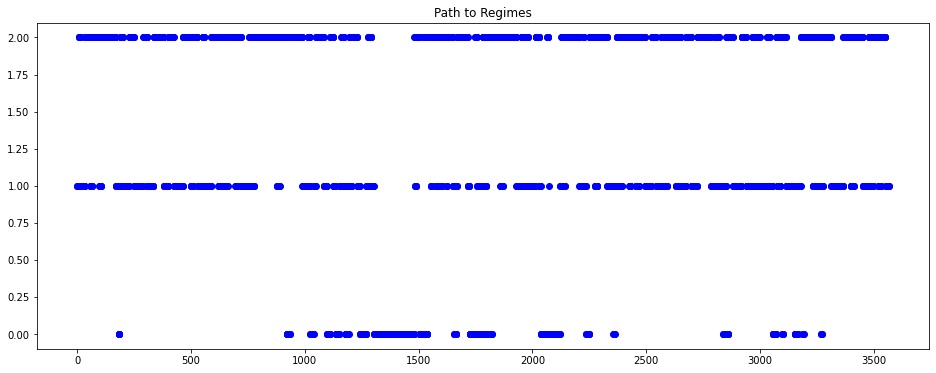

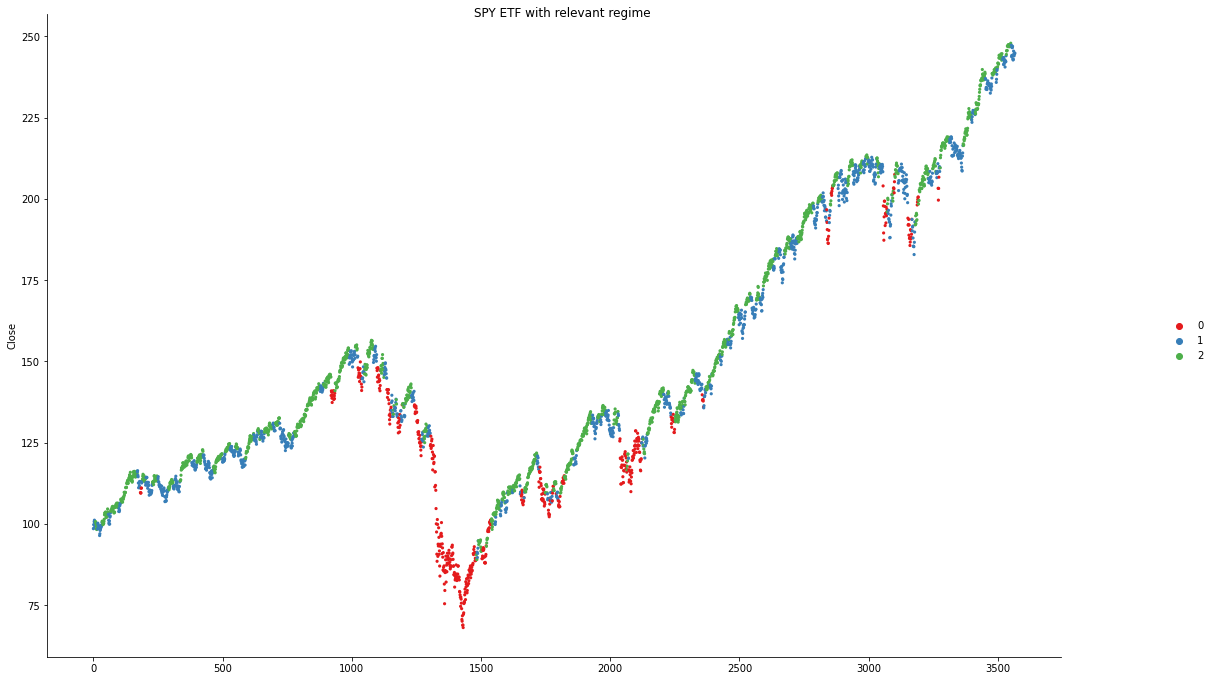



Model Score: 3925.7557460271537


,prediction,Return,MA_15_days
0,0,-0.115995,-0.031559
1,1,-0.010214,-0.010761
2,2,0.107894,0.025240


The Winner State is: 2 / The Loser State is: 0


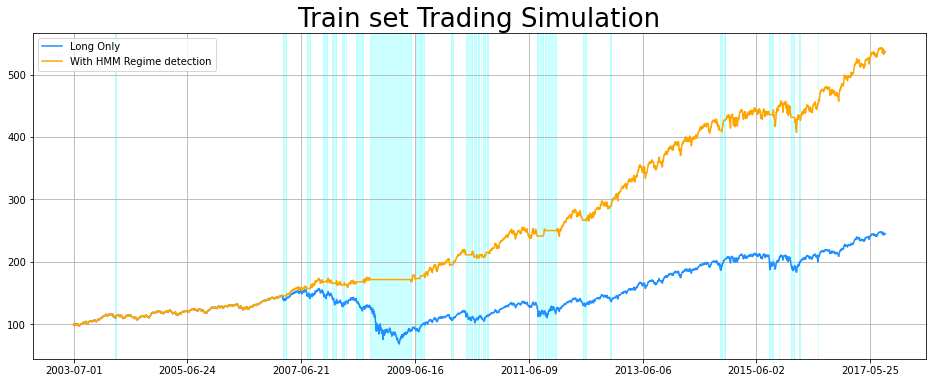

For the buy and hold trading strategy => Overall return = 148.50%  ~  Yearly return = 6.63%  ~  Z-score = 1.661
For the HMM based    trading strategy => Overall return = 444.80%  ~  Yearly return = 12.71%  ~  Z-score = 4.287


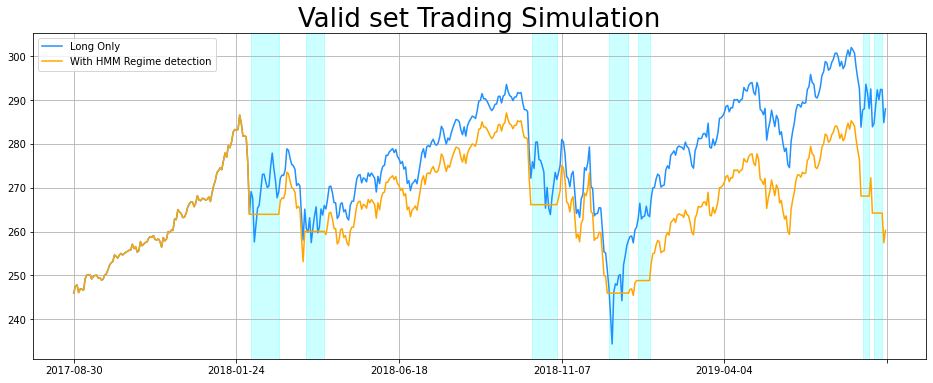

For the buy and hold trading strategy => Overall return = 17.07%  ~  Yearly return = 8.25%  ~  Z-score = 0.864
For the HMM based    trading strategy => Overall return = 5.80%  ~  Yearly return = 2.87%  ~  Z-score = 0.429

NOW USING hist_vol_15_days ....




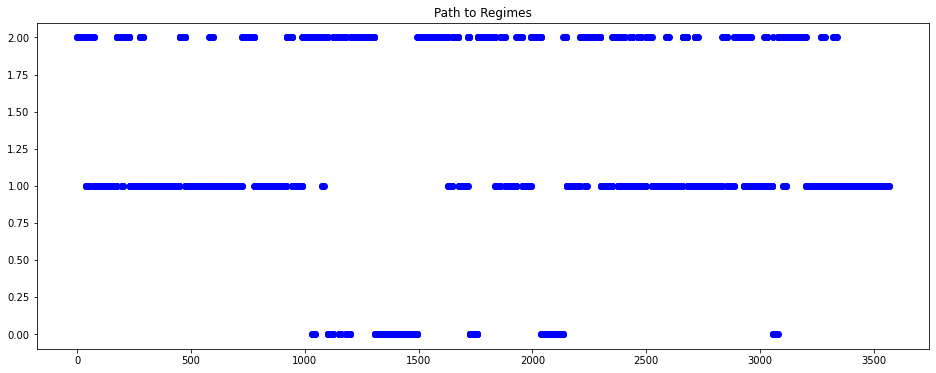

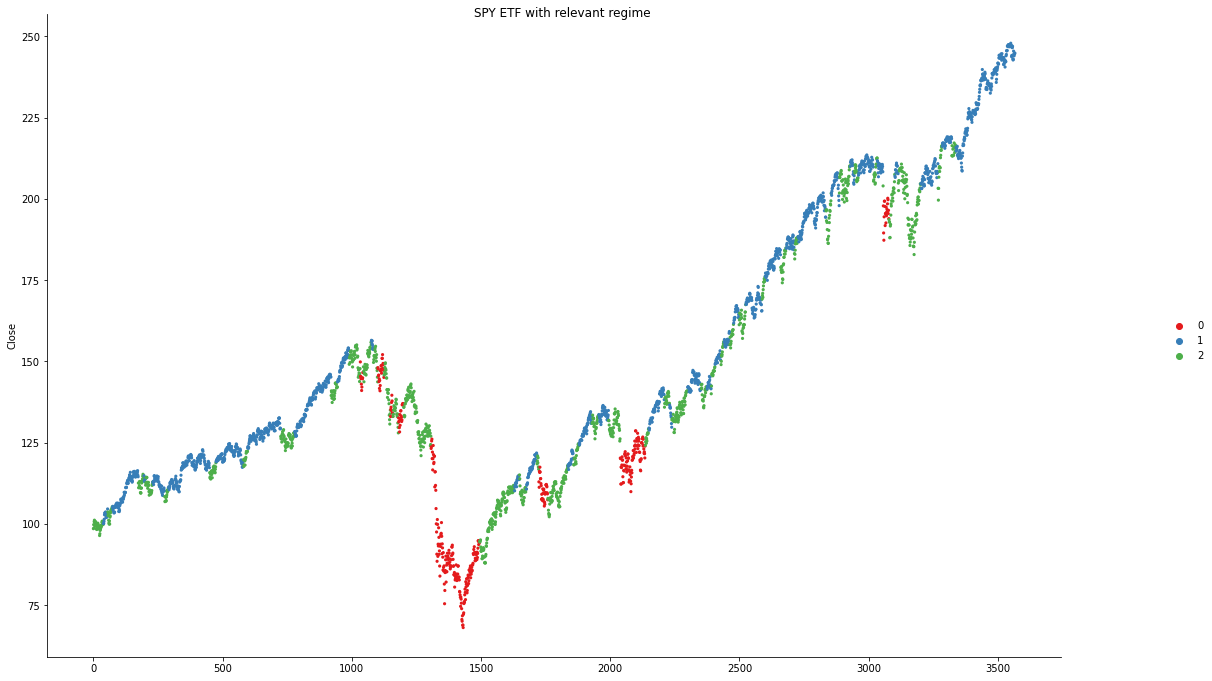



Model Score: 2656.9164206364244


,prediction,Return,hist_vol_15_days
0,0,-0.062461,0.378971
1,1,0.048450,0.089546
2,2,0.039435,0.165898


The Winner State is: 1 / The Loser State is: 0


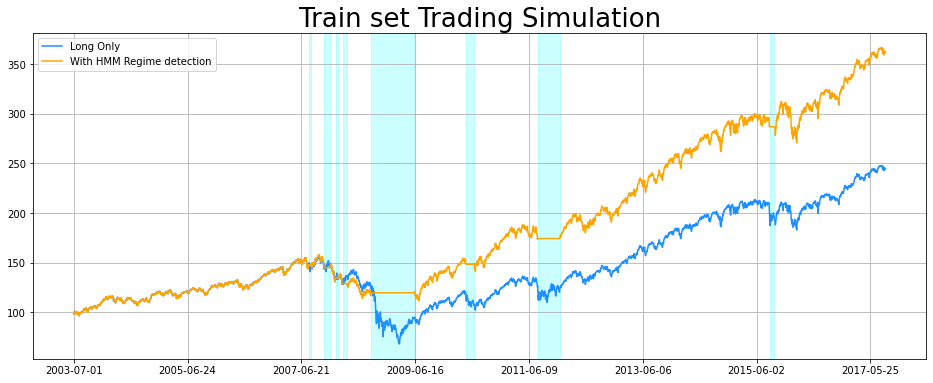

For the buy and hold trading strategy => Overall return = 148.50%  ~  Yearly return = 6.63%  ~  Z-score = 1.661
For the HMM based    trading strategy => Overall return = 267.68%  ~  Yearly return = 9.62%  ~  Z-score = 3.105


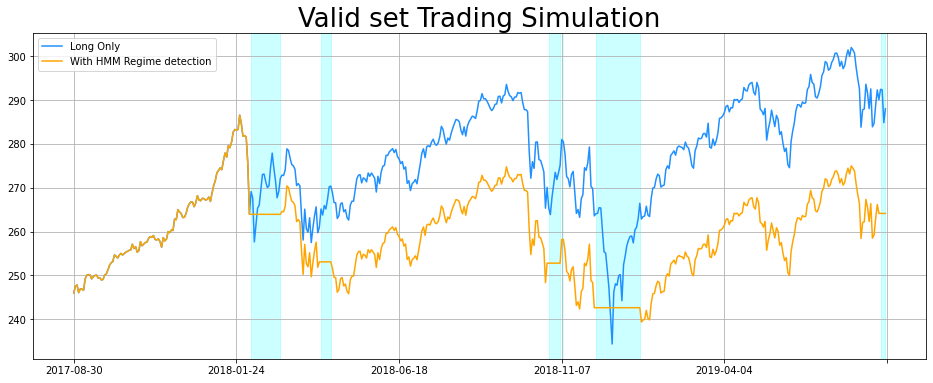

For the buy and hold trading strategy => Overall return = 17.07%  ~  Yearly return = 8.25%  ~  Z-score = 0.864
For the HMM based    trading strategy => Overall return = 7.37%  ~  Yearly return = 3.64%  ~  Z-score = 0.501

NOW USING MA_30_days ....




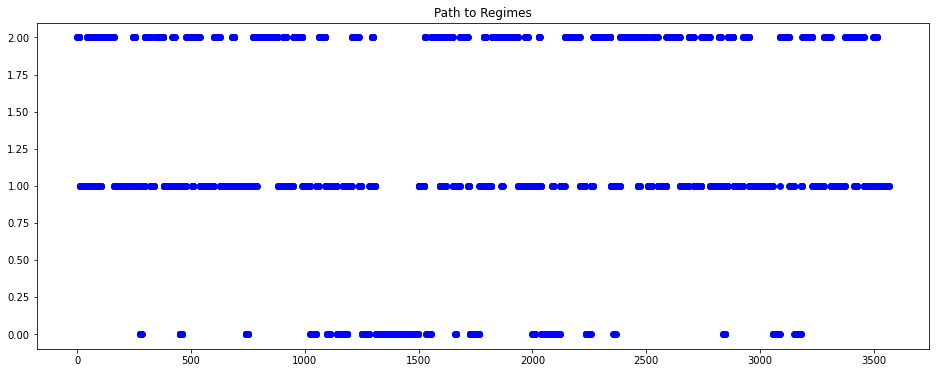

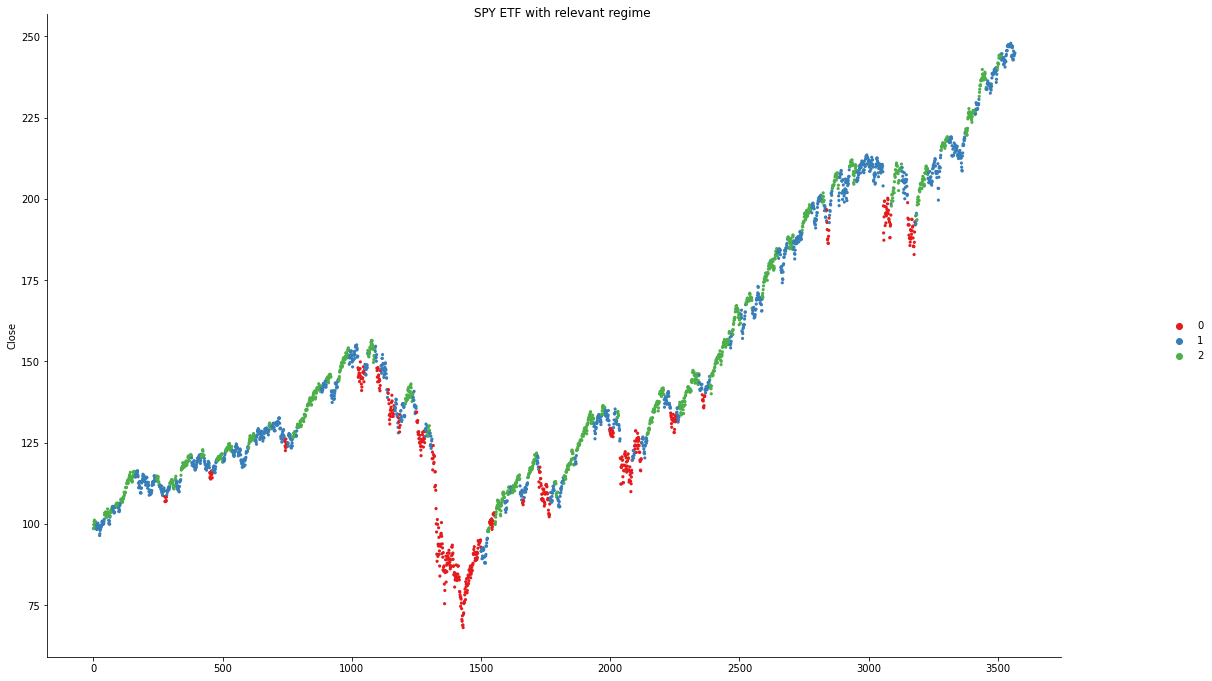



Model Score: 5501.926547075883


,prediction,Return,MA_30_days
0,0,-0.100003,-0.026343
1,1,0.022713,-0.001221
2,2,0.098355,0.022592


The Winner State is: 2 / The Loser State is: 0


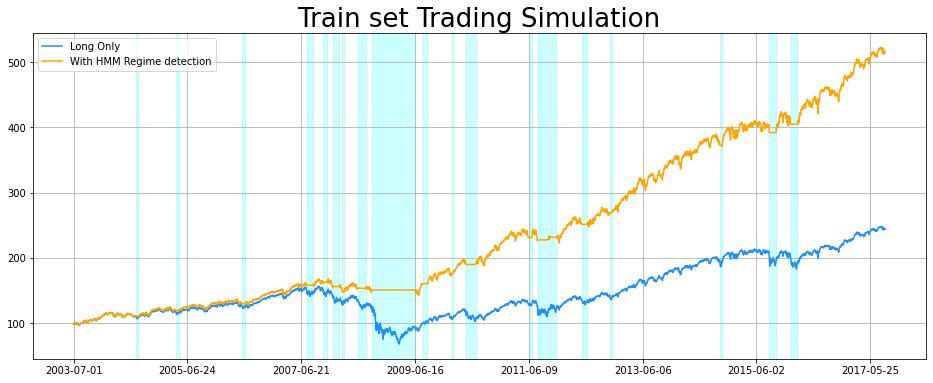

For the buy and hold trading strategy => Overall return = 148.50%  ~  Yearly return = 6.63%  ~  Z-score = 1.661
For the HMM based    trading strategy => Overall return = 423.79%  ~  Yearly return = 12.39%  ~  Z-score = 4.168


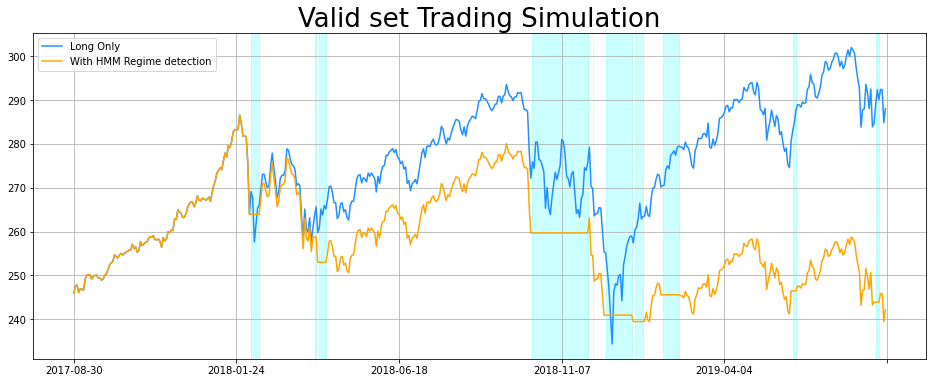

For the buy and hold trading strategy => Overall return = 17.07%  ~  Yearly return = 8.25%  ~  Z-score = 0.864
For the HMM based    trading strategy => Overall return = -1.58%  ~  Yearly return = -0.80%  ~  Z-score = -0.016

NOW USING hist_vol_30_days ....




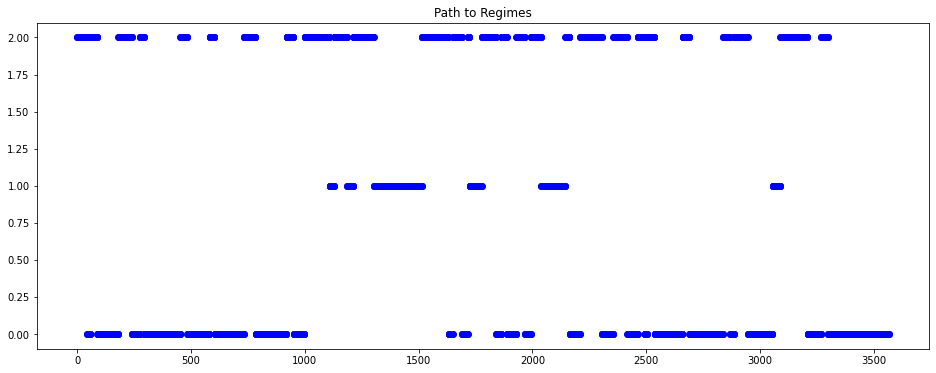

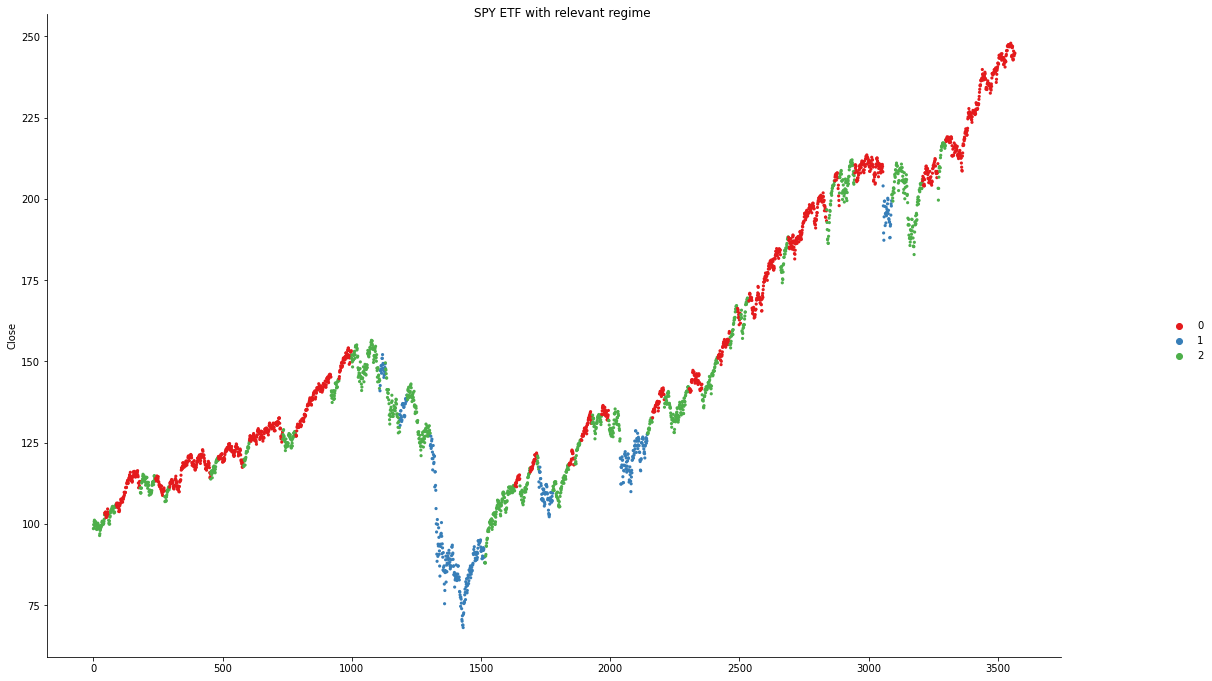



Model Score: 2852.7799538918953


,prediction,Return,hist_vol_30_days
0,0,0.044185,0.094551
1,1,-0.046471,0.359527
2,2,0.043797,0.158178


The Winner State is: 0 / The Loser State is: 1


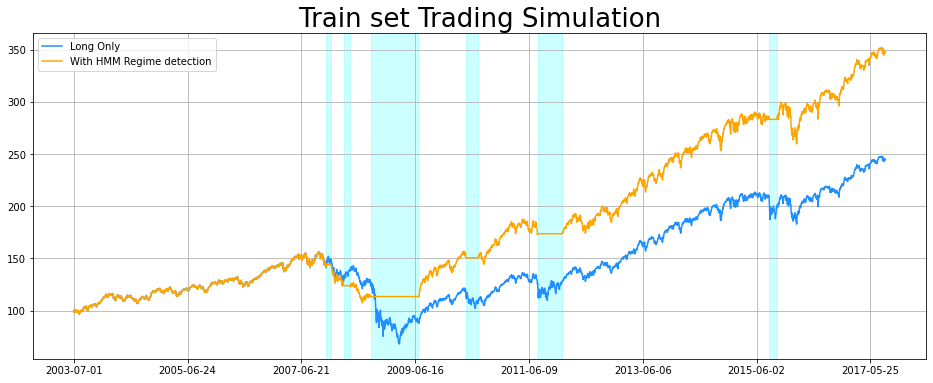

For the buy and hold trading strategy => Overall return = 148.50%  ~  Yearly return = 6.63%  ~  Z-score = 1.661
For the HMM based    trading strategy => Overall return = 252.86%  ~  Yearly return = 9.30%  ~  Z-score = 3.048


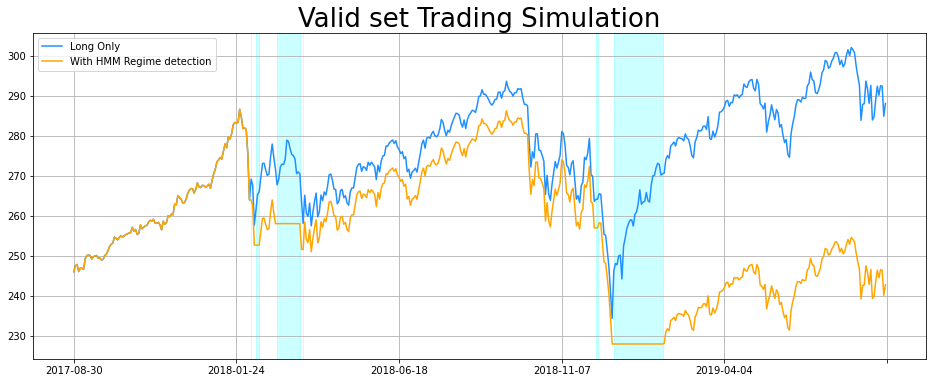

For the buy and hold trading strategy => Overall return = 17.07%  ~  Yearly return = 8.25%  ~  Z-score = 0.864
For the HMM based    trading strategy => Overall return = -1.33%  ~  Yearly return = -0.67%  ~  Z-score = 0.023

NOW USING MA_60_days ....




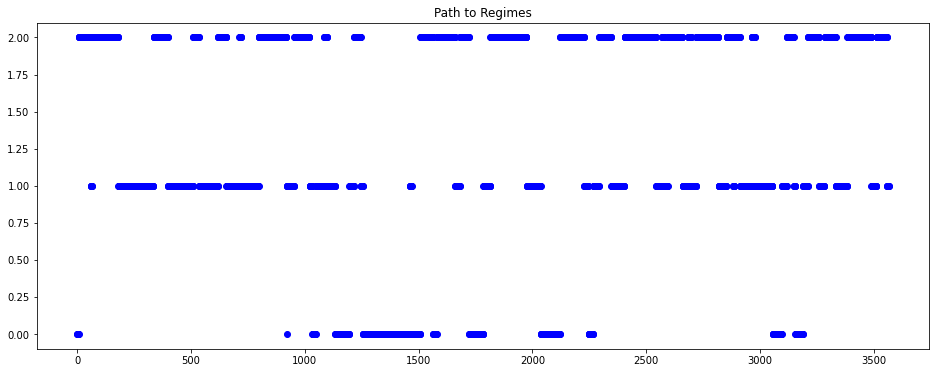

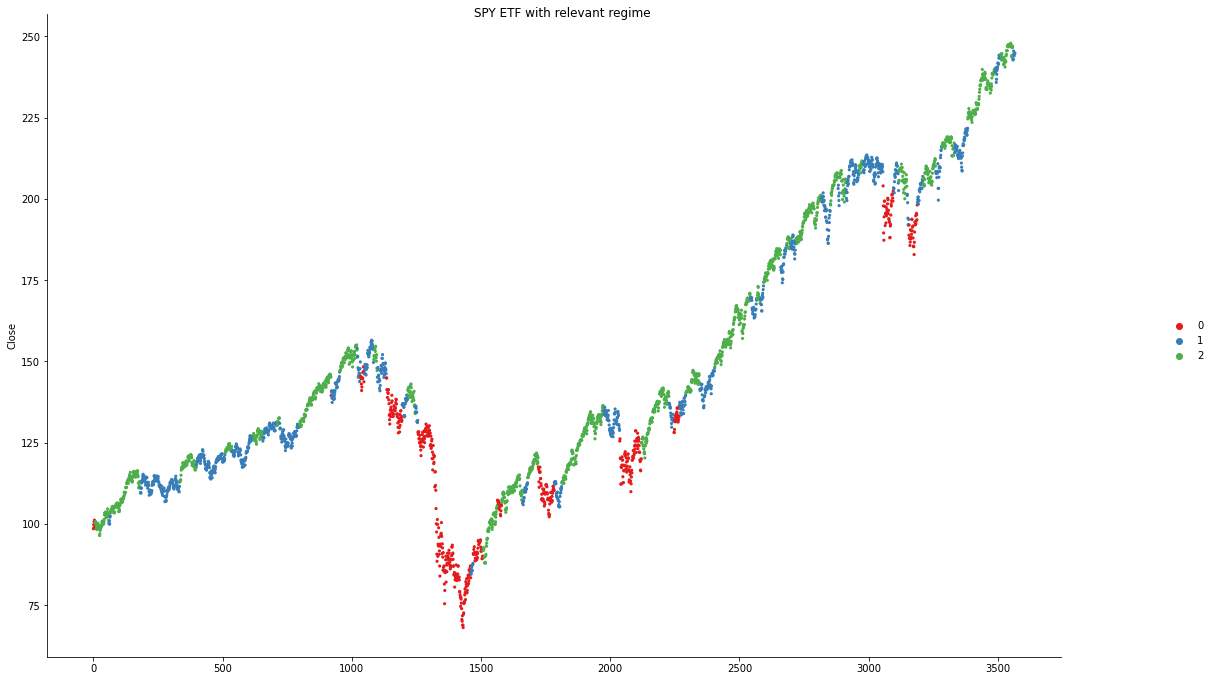



Model Score: 7014.885638069126


,prediction,Return,MA_60_days
0,0,-0.074616,-0.020316
1,1,0.026040,-0.000246
2,2,0.074085,0.016009


The Winner State is: 2 / The Loser State is: 0


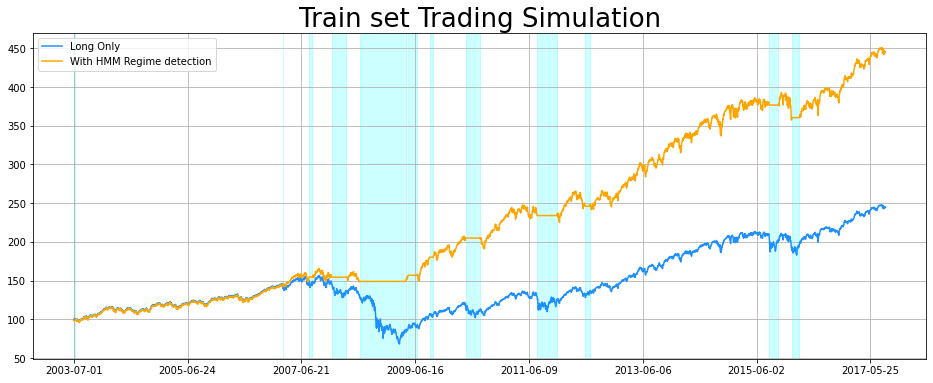

For the buy and hold trading strategy => Overall return = 148.50%  ~  Yearly return = 6.63%  ~  Z-score = 1.661
For the HMM based    trading strategy => Overall return = 352.33%  ~  Yearly return = 11.24%  ~  Z-score = 3.832


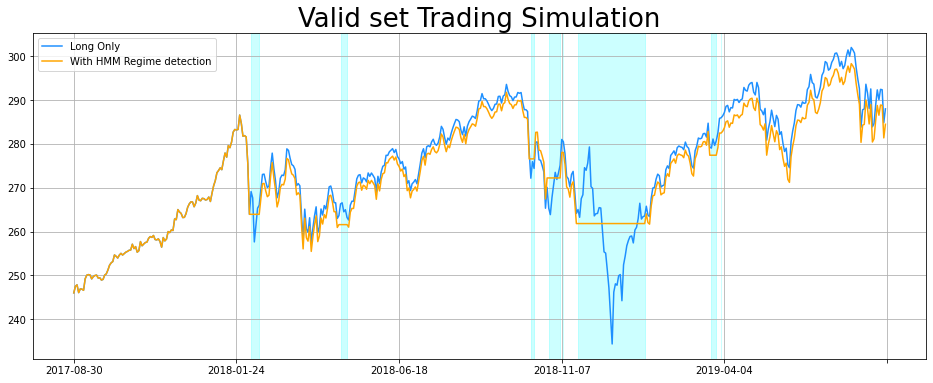

For the buy and hold trading strategy => Overall return = 17.07%  ~  Yearly return = 8.25%  ~  Z-score = 0.864
For the HMM based    trading strategy => Overall return = 15.64%  ~  Yearly return = 7.58%  ~  Z-score = 0.948

NOW USING hist_vol_60_days ....




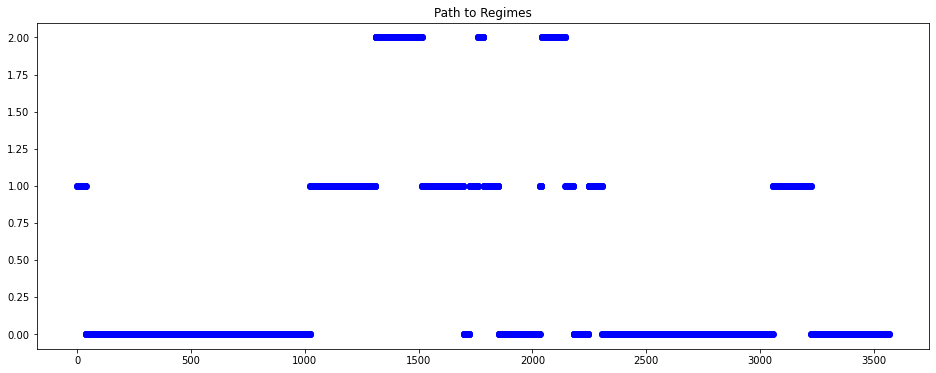

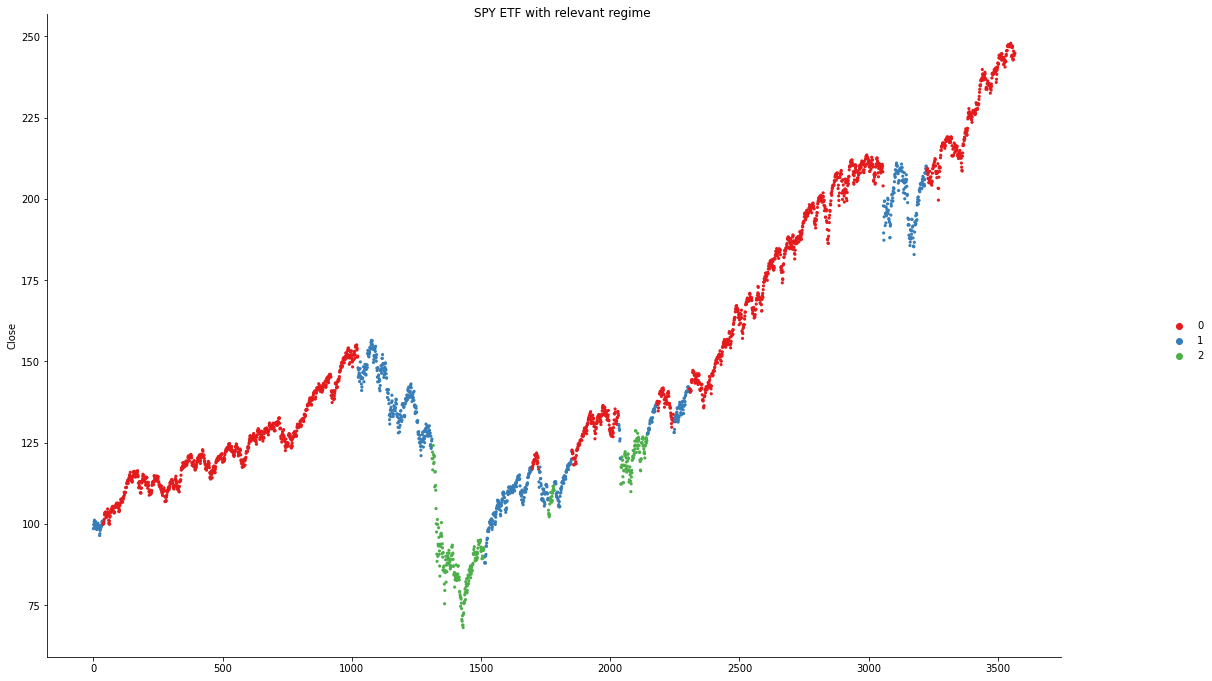



Model Score: 3198.082539859448


,prediction,Return,hist_vol_60_days
0,0,0.044260,0.109705
1,1,0.028488,0.185487
2,2,-0.039931,0.404027


The Winner State is: 0 / The Loser State is: 2


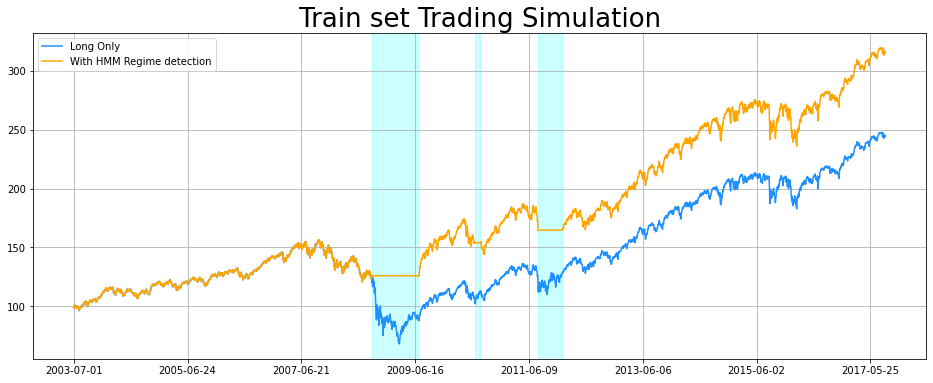

For the buy and hold trading strategy => Overall return = 148.50%  ~  Yearly return = 6.63%  ~  Z-score = 1.661
For the HMM based    trading strategy => Overall return = 220.61%  ~  Yearly return = 8.57%  ~  Z-score = 2.646


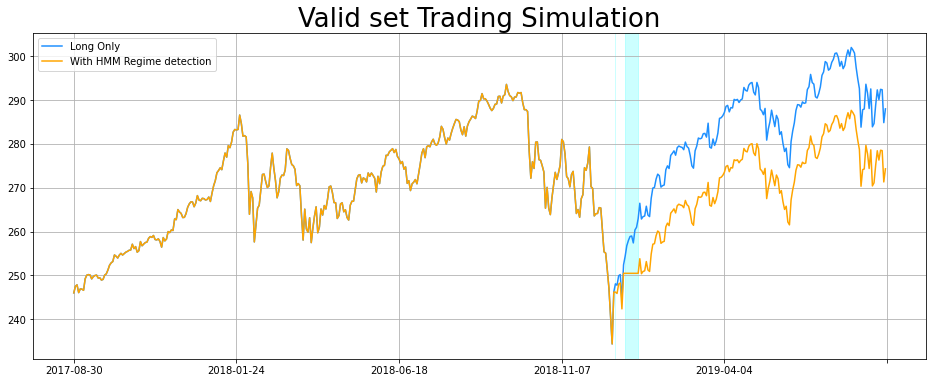

For the buy and hold trading strategy => Overall return = 17.07%  ~  Yearly return = 8.25%  ~  Z-score = 0.864
For the HMM based    trading strategy => Overall return = 11.51%  ~  Yearly return = 5.63%  ~  Z-score = 0.632

NOW USING MA_120_days ....




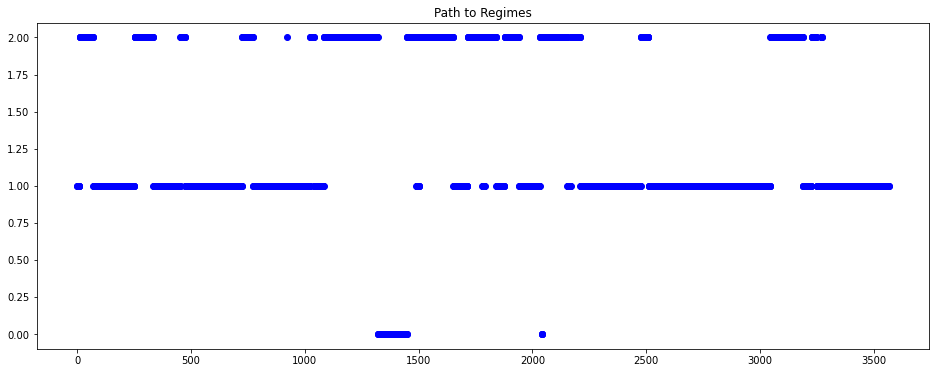

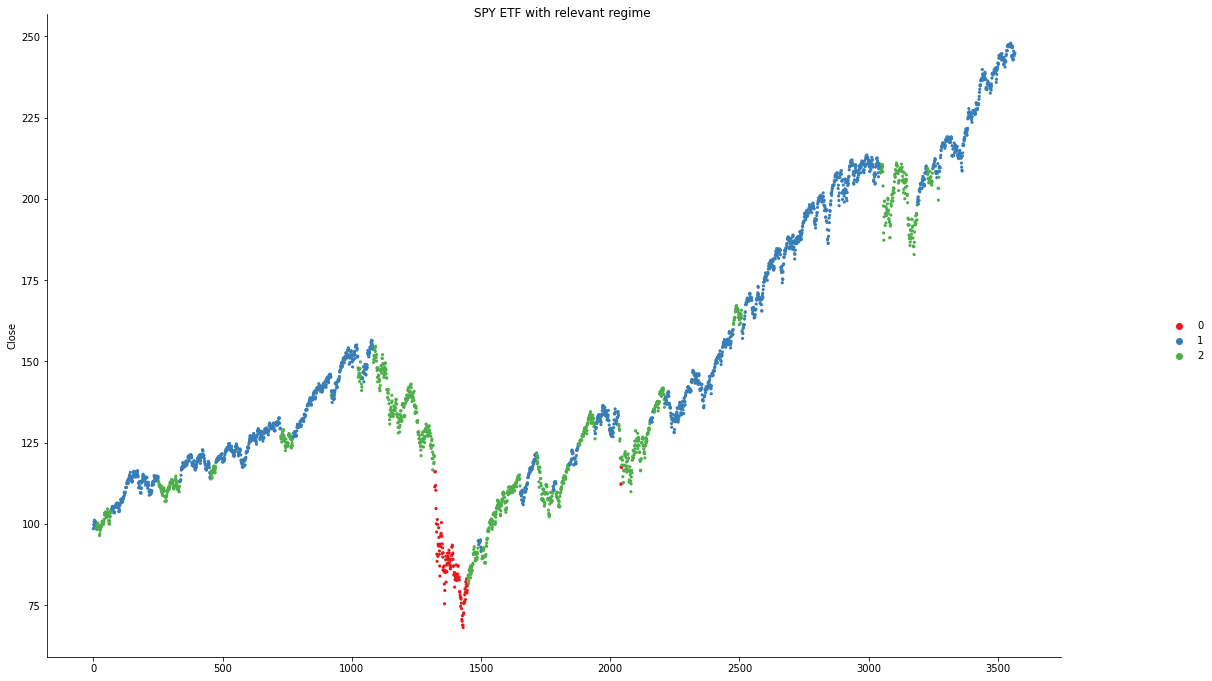



Model Score: 7772.65293438109


,prediction,Return,MA_120_days
0,0,-0.250564,-0.052896
1,1,0.064875,0.008703
2,2,0.003224,0.002607


The Winner State is: 1 / The Loser State is: 0


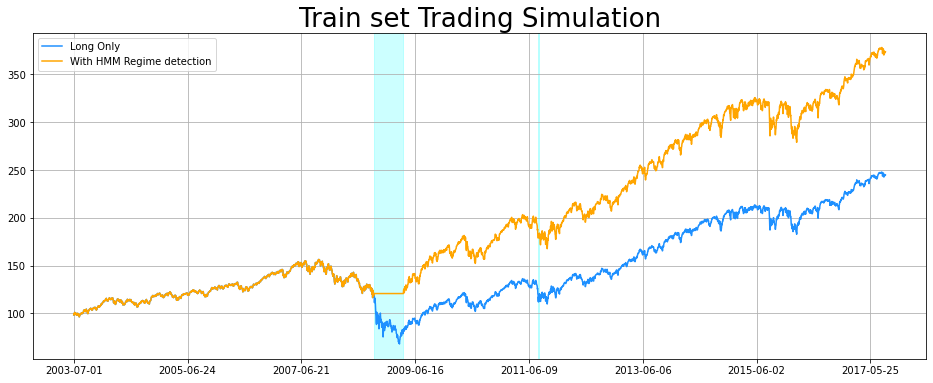

For the buy and hold trading strategy => Overall return = 148.50%  ~  Yearly return = 6.63%  ~  Z-score = 1.661
For the HMM based    trading strategy => Overall return = 279.17%  ~  Yearly return = 9.86%  ~  Z-score = 2.727


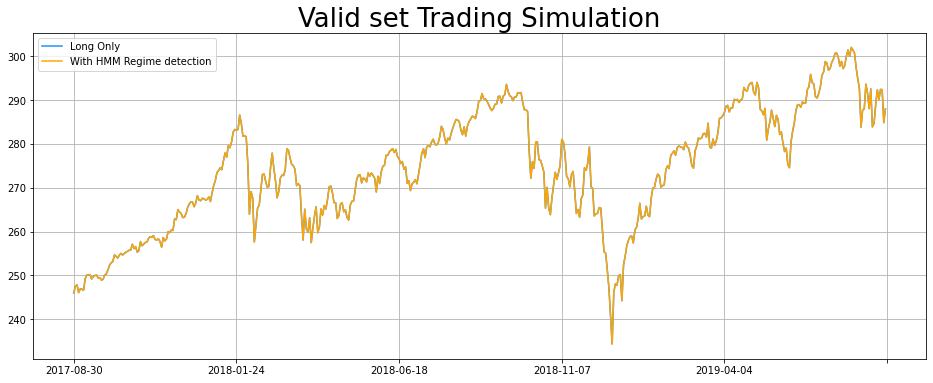

For the buy and hold trading strategy => Overall return = 17.07%  ~  Yearly return = 8.25%  ~  Z-score = 0.864
For the HMM based    trading strategy => Overall return = 17.07%  ~  Yearly return = 8.25%  ~  Z-score = 0.864

NOW USING hist_vol_120_days ....




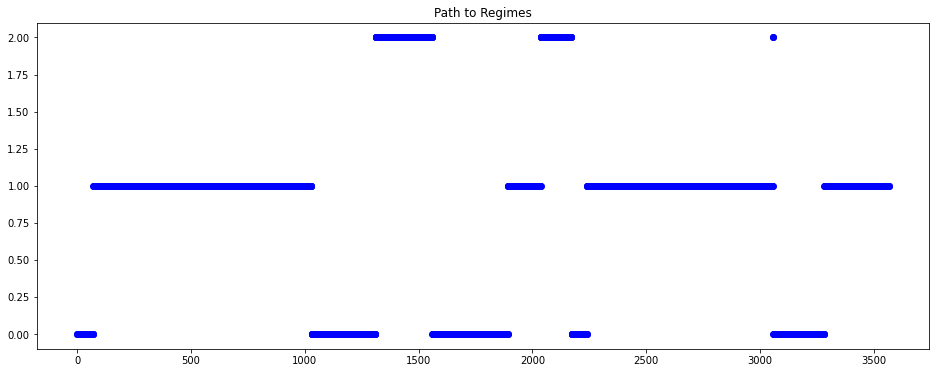

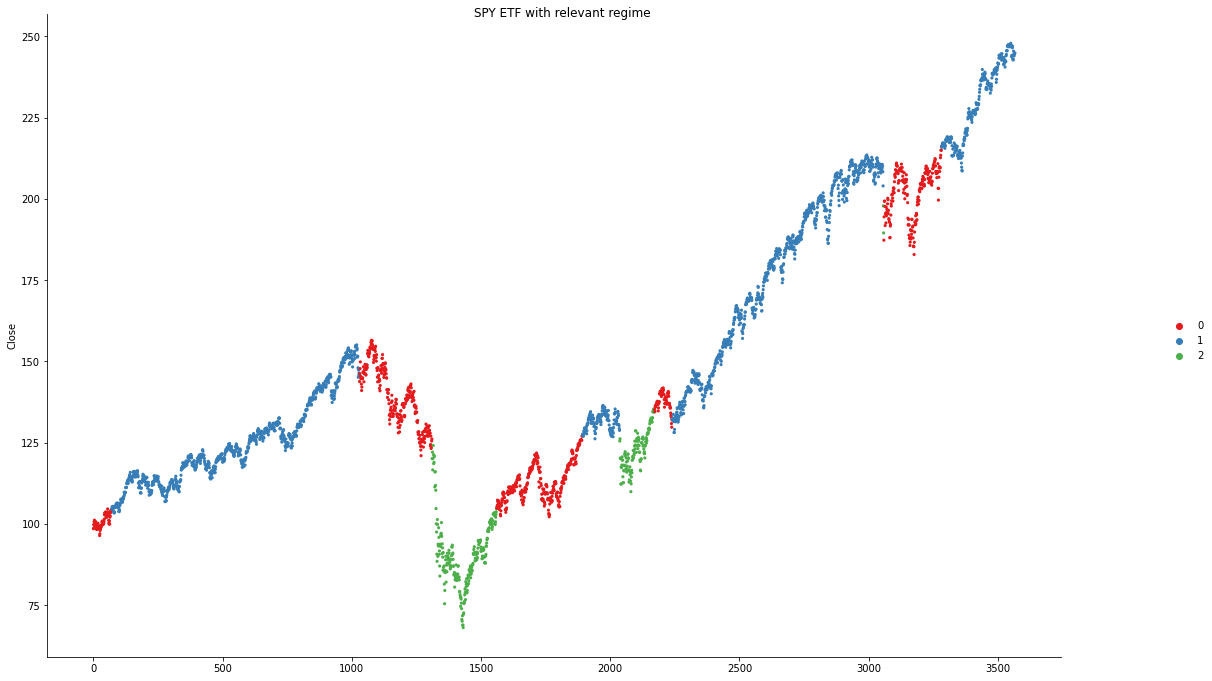



Model Score: 3697.1253910590285


,prediction,Return,hist_vol_120_days
0,0,0.027336,0.182948
1,1,0.044270,0.111637
2,2,-0.021545,0.376762


The Winner State is: 1 / The Loser State is: 2


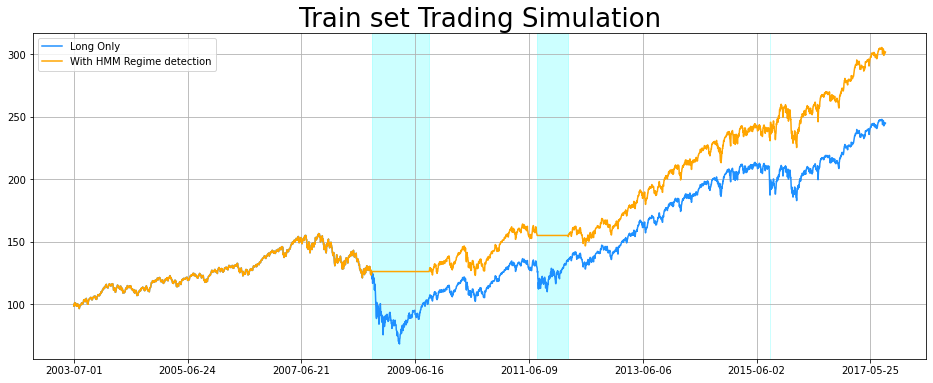

For the buy and hold trading strategy => Overall return = 148.50%  ~  Yearly return = 6.63%  ~  Z-score = 1.661
For the HMM based    trading strategy => Overall return = 206.20%  ~  Yearly return = 8.22%  ~  Z-score = 2.583


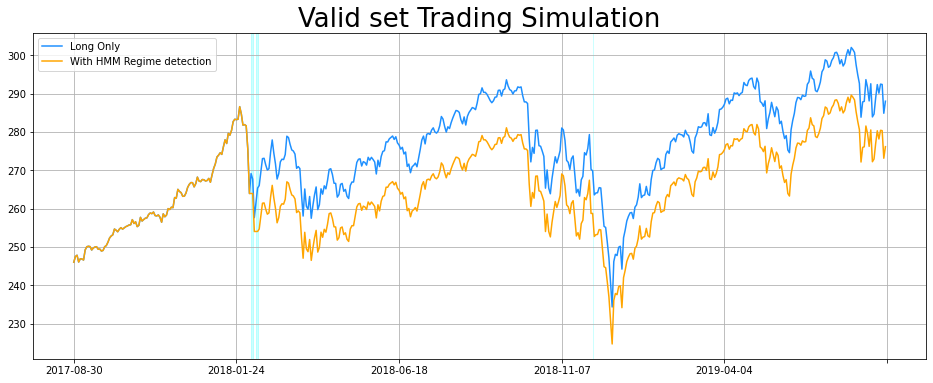

For the buy and hold trading strategy => Overall return = 17.07%  ~  Yearly return = 8.25%  ~  Z-score = 0.864
For the HMM based    trading strategy => Overall return = 12.25%  ~  Yearly return = 5.98%  ~  Z-score = 0.666


WE WILL KEEP THE MODEL BASED ON MA_60_days, HAVING THE BEST Z_SCORE: 0.948 ON THE VALIDATION SET


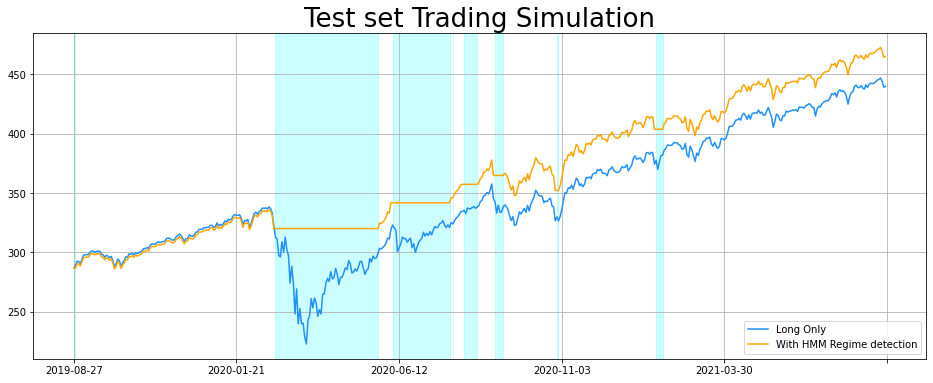

For the buy and hold trading strategy => Overall return = 53.33%  ~  Yearly return = 24.08%  ~  Z-score = 1.385
For the HMM based    trading strategy => Overall return = 62.15%  ~  Yearly return = 27.64%  ~  Z-score = 3.039


In [46]:
run_hmm_model_valid(testDf)

EXCELLENT!!! With a Z_Score above 3 compared with 1.4 for the Long-Only we demonstrated an outstanding performance on the Test Set !!!